### Project outline: 

- Read data into Jupyter notebook, use pandas to import data into a data frame
- Preprocess data: Explore data, check for missing data and apply data scaling. Justify the type of scaling used.
- Goal is to predict the **total transaction revenue**. 
- Decide aboute a good evaluation strategy and justify your choice.
- Split dataset into train and test dataset. 
- Choose two supervised learning model of your choice to train on train set. Use proper methods to find the best parameters. Evaluate your method on test data according to evaluation strategy. 
- Choose two unsupervised learning models, clustering, to train on your dataset. Discuss results. 
- Choose two unsupervised learning models, dimentionally reduction, and train it your dataset. Now use the same supervised learning models above on reduced dataset. Can you see any differences? Discuss the result. 
- Use a neural network model on your dataset. Compare the result with other two supervised learning models. Which model performs better? 

### Deliverables:
- Submit IPython notebook. Use markdown to provide an inline comments for this project.
- Submit only one notebook. Before submitting, make sure everything runs as expected. To check that, restart the kernel (in the menubar, select Kernel > Restart) and then run all cells (in the menubar, select Cell > Run All).
- Visualization expected. 

### Dataset Description
This is an online Merchandise Store customer dataset. Goal is to predict the total transaction revenue. 
Each row in the dataset is one visit to the store. 

Data Fields
- fullVisitorId- A unique identifier for each user of the Google Merchandise Store.
- channelGrouping - The channel via which the user came to the Store.
- date - The date on which the user visited the Store.
- device - The specifications for the device used to access the Store.
- geoNetwork - This section contains information about the geography of the user.
- sessionId - A unique identifier for this visit to the store.
- socialEngagementType - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
- totals - This section contains aggregate values across the session.
- trafficSource - This section contains information about the Traffic Source from which the session originated.
- visitId - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.
- visitNumber - The session number for this user. If this is the first session, then this is set to 1.
- visitStartTime - The timestamp (expressed as POSIX time).
- hits - This row and nested fields are populated for any and all types of hits. Provides a record of all page visits.
- customDimensions - This section contains any user-level or session-level custom dimensions that are set for a session. This is a repeated field and has an entry for each dimension that is set.

In [9]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns; sns.set()
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import json
import ast
from pandas.io.json import json_normalize
from scipy import stats
from datetime import datetime
from scipy.stats import kurtosis, skew 
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score

In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
from sklearn.linear_model import LinearRegression as lm
from sklearn import tree
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_validation import cross_val_predict
from sklearn import metrics
import numpy as np
from sklearn.pipeline import make_pipeline
import warnings
from scipy.stats import mstats
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cluster import KMeans
from sklearn import cluster, metrics

In [12]:
from sklearn.mixture import GaussianMixture 

In [13]:
from sklearn import mixture
import itertools
from scipy import linalg
import matplotlib as mpl
from sklearn.metrics import mean_squared_error

In [14]:
import os
import json
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [15]:
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.manifold import Isomap

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Dropout
from keras import optimizers

In [6]:
def convert_to_datetime(frame):
    frame['date'] = frame['date'].astype(str)
    frame['date'] = frame['date'].apply(lambda x : x[:4] + "-" + x[4:6] + "-" + x[6:])
    frame['date'] = pd.to_datetime(frame['date'])
    return frame

In [7]:
def read_data(csv_path='data.csv', nrows=None):

    JSON_COLUMNS = ['device', 'geoNetwork', 'trafficSource']

    df = pd.read_csv(csv_path, 
                     converters={column: ast.literal_eval for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, 
                     nrows=nrows)
    nan_list = ["not available in demo dataset",
            "unknown.unknown",
            "(not provided)",
            "(not set)", 
            "Not Socially Engaged"," : "
    ] 
    nan_dict = {nl:np.nan for nl in nan_list}
    
    device_list=df['device'].tolist()
    df.drop('hits',axis=1,inplace=True)
    
    df['customDimensions']=df['customDimensions'].apply(ast.literal_eval)
    df['customDimensions']=df['customDimensions'].str[0]
    df['customDimensions']=df['customDimensions'].apply(lambda x: {'index':np.NaN,'value':np.NaN} if pd.isnull(x) else x)
    
    JSON_COLUMNS = ['device', 'geoNetwork', 'trafficSource','customDimensions']

    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
        df.replace(nan_dict, inplace=True) 
        
    convert_to_datetime(df)
    df.set_index('date',inplace=True)
    return df

In [19]:
def plot_corr_heatmap(df_corr):
    mask = np.zeros_like(df_corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(16, 8))
    colormap = sns.diverging_palette(10, 140, as_cmap=True)
    sns.heatmap(df_corr, mask=mask, cmap=colormap, vmax=1.0,vmin=-1.0,
                square=True, 
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);

In [20]:
def ifsort(df, sorty=True):
    return df.sort_values(ascending=True) if sorty is True else df

def col_by_size(df, col, threshold=0, sorty=True):
    return ifsort(df.fillna({col: -1}).groupby(col).size().apply(lambda x: (x if x>threshold else np.nan)).dropna(), sorty=sorty)

def col_by_col_count(df, col1, col2, threshold=0, sorty=True):
    return ifsort(df.fillna({col1: -1}).groupby(col1)[col2].count().apply(lambda x: (x if x>threshold else np.nan)).dropna(), sorty=sorty)

def col_by_col_sum(df, col1, col2, threshold=0, sorty=True):
    return ifsort(df.fillna({col1: -1}).groupby(col1)[col2].sum(numeric_only=True).apply(lambda x: (x if x>threshold else np.nan)).dropna(), sorty=sorty)

def myautopct(pct):
    return ('%.2f' % pct) if pct > 2 else ''

def get_colors(df):
    colors = []
    for i in df.index:
        s = str(abs(hash(str(i))))
        colors.append( ( float('0.'+s[0]), float('0.'+s[1]), float('0.'+s[2]) ) )
    return colors

def get_labels(df):
    labels = []
    total = df.values.sum()
    for i,v in dict(df).items():
        pct = v / (total/100)
        labels.append( ( i if pct > 1 else '' ) )
    return labels

def mypie(df, title, angle=0, autocol=True, autolab=True):
    colors = get_colors(df) if autocol is True else None
    labels = get_labels(df) if autolab is True else None
    
    df.plot(kind='pie', radius=1.2, startangle=angle, autopct=myautopct, pctdistance=0.8,
        figsize=(5, 5), rotatelabels=False, legend=True, colors=colors, labels=labels, explode=[0.02]*df.size);
    plt.title(title, weight='bold', size=14, x=2.0, y=-0.01);
    plt.xlabel('')
    plt.ylabel('')
    plt.legend(bbox_to_anchor=(2.5, 1.0), ncol=2, fontsize=10, fancybox=True, shadow=True);
    
def make_revenue_pie(df, col, unique=500, minperc=0, threshold=0, angle=0, sorty=True):
    print ('\n\n'+'Pie Chart',col)
    uentries = df[col].astype(str).unique().size
    percvalid = df[col].notna().sum() / (df[col].size / 100)
    if percvalid < minperc:
        print ("NO PIE because {:s} has only {:1.1f}% non-Null entries (min={:d}%)".format(col, percvalid, minperc))
    elif uentries > unique:
        print ("NO PIE because there are over",unique,"unique",col,"entries")
    elif uentries <= 1:
        print ("NO PIE because all entries are identical")
    else:
        dfrev = col_by_col_count(df, col, 'totals_transactionRevenue', threshold=threshold, sorty=sorty)
        if not dfrev.empty:
            dfsum = col_by_col_sum(df, col, 'totals_transactionRevenue', threshold=threshold, sorty=sorty)
            dfgen = col_by_size(df, col, threshold=threshold, sorty=sorty)
            mypie(dfgen, col+' prevalence',           angle=angle, autocol=True); plt.show()
            mypie(dfrev, col+' by revenue instances', angle=angle, autocol=True); plt.show()
            mypie(dfsum, col+' by revenue sum',       angle=angle, autocol=True); plt.show()
        else:
            print ("NO PIE because",col," does not have a unique entry with more than",threshold,"revenue instances")


## Data Preprocessing

###### Exploratory Analysis of Data and Missing Value Treatment

In [16]:
data=read_data()

In [27]:
data.shape

(20000, 58)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20000 entries, 2017-10-16 to 2017-11-10
Data columns (total 58 columns):
channelGrouping                                      20000 non-null object
fullVisitorId                                        20000 non-null object
socialEngagementType                                 0 non-null float64
visitId                                              20000 non-null int64
visitNumber                                          20000 non-null int64
visitStartTime                                       20000 non-null int64
totals_bounces                                       9873 non-null float64
totals_hits                                          20000 non-null int64
totals_newVisits                                     15088 non-null float64
totals_pageviews                                     19999 non-null float64
totals_sessionQualityDim                             9120 non-null float64
totals_timeOnSite                                    1

In [11]:
data.head()

,channelGrouping,fullVisitorId,socialEngagementType,visitId,visitNumber,visitStartTime,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,...,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,customDimensions.index,customDimensions.value
date,,,,,,,,,,,,,,,,,,,,,
2017-10-16,Organic Search,3162355547410993243,NaN,1508198450,1,1508198450,1.0,1,1.0,1.0,...,NaN,NaN,NaN,NaN,water bottle,organic,NaN,google,4,EMEA
2017-10-16,Referral,8934116514970143966,NaN,1508176307,6,1508176307,NaN,2,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com,4,North America
2017-10-16,Direct,7992466427990357681,NaN,1508201613,1,1508201613,NaN,2,1.0,2.0,...,NaN,NaN,NaN,True,NaN,(none),NaN,(direct),4,North America
2017-10-16,Organic Search,9075655783635761930,NaN,1508169851,1,1508169851,NaN,2,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,organic,NaN,google,4,EMEA
2017-10-16,Organic Search,6960673291025684308,NaN,1508190552,1,1508190552,NaN,2,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,organic,NaN,google,4,Central America


In [13]:
print("Number of unique values in each column (incl. nans)\n")
for col in data.columns:
    try:
        print(col, ':', data[col].nunique(dropna=False))
    except TypeError:
        a=data[col].astype('str')
       
        print( col, ':', a.nunique(dropna=False), ' --------------------------- List')
# Clean workspace
del(col)

Number of unique values in each column (incl. nans)

channelGrouping : 7
fullVisitorId : 18384
socialEngagementType : 1
visitId : 19667
visitNumber : 99
visitStartTime : 19666
totals_bounces : 2
totals_hits : 114
totals_newVisits : 2
totals_pageviews : 81
totals_sessionQualityDim : 94
totals_timeOnSite : 1414
totals_totalTransactionRevenue : 187
totals_transactionRevenue : 169
totals_transactions : 4
totals_visits : 1
device.browser : 25
device.browserSize : 1
device.browserVersion : 1
device.deviceCategory : 3
device.flashVersion : 1
device.isMobile : 2
device.language : 1
device.mobileDeviceBranding : 1
device.mobileDeviceInfo : 1
device.mobileDeviceMarketingName : 1
device.mobileDeviceModel : 1
device.mobileInputSelector : 1
device.operatingSystem : 16
device.operatingSystemVersion : 1
device.screenColors : 1
device.screenResolution : 1
geoNetwork.city : 161
geoNetwork.cityId : 1
geoNetwork.continent : 6
geoNetwork.country : 155
geoNetwork.latitude : 1
geoNetwork.longitude : 1
geoNe

In [17]:
print('Data shape before dropping constant columns:', data.shape)

print('\nColumns being dropped:')

for col in data.columns:
    try:
        if (data[col].nunique(dropna=False) == 1):
            del(data[col])
            print(col)
    except TypeError:
        a=data[col].astype('str')
        if (a.nunique(dropna=False) == 1):
            del(data[col])
            print(col)
del(col)

print('\nData shape after dropping constant columns:', data.shape)

Data shape before dropping constant columns: (20000, 58)

Columns being dropped:
socialEngagementType
totals_visits
device.browserSize
device.browserVersion
device.flashVersion
device.language
device.mobileDeviceBranding
device.mobileDeviceInfo
device.mobileDeviceMarketingName
device.mobileDeviceModel
device.mobileInputSelector
device.operatingSystemVersion
device.screenColors
device.screenResolution
geoNetwork.cityId
geoNetwork.latitude
geoNetwork.longitude
geoNetwork.networkLocation
trafficSource.adwordsClickInfo.criteriaParameters

Data shape after dropping constant columns: (20000, 39)


In [15]:
print("Number of unique values in each column (incl. nans)\n")
for col in data.columns:
    try:
        print(col, ':', data[col].nunique(dropna=False))
    except TypeError:
        a=data[col].astype('str')
        
        print( col, ':', a.nunique(dropna=False), ' --------------------------- List')
# Clean workspace
del(col)

Number of unique values in each column (incl. nans)

channelGrouping : 7
fullVisitorId : 18384
visitId : 19667
visitNumber : 99
visitStartTime : 19666
totals_bounces : 2
totals_hits : 114
totals_newVisits : 2
totals_pageviews : 81
totals_sessionQualityDim : 94
totals_timeOnSite : 1414
totals_totalTransactionRevenue : 187
totals_transactionRevenue : 169
totals_transactions : 4
device.browser : 25
device.deviceCategory : 3
device.isMobile : 2
device.operatingSystem : 16
geoNetwork.city : 161
geoNetwork.continent : 6
geoNetwork.country : 155
geoNetwork.metro : 31
geoNetwork.networkDomain : 2515
geoNetwork.region : 124
geoNetwork.subContinent : 22
trafficSource.adContent : 35
trafficSource.adwordsClickInfo.adNetworkType : 3
trafficSource.adwordsClickInfo.gclId : 596
trafficSource.adwordsClickInfo.isVideoAd : 2
trafficSource.adwordsClickInfo.page : 4
trafficSource.adwordsClickInfo.slot : 3
trafficSource.campaign : 17
trafficSource.isTrueDirect : 2
trafficSource.keyword : 112
trafficSource.m

###### Checking for missing values

In [9]:
data.isnull().sum().sort_values(ascending=False)

totals_transactionRevenue                       19807
totals_totalTransactionRevenue                  19807
totals_transactions                             19804
trafficSource.adContent                         19479
trafficSource.adwordsClickInfo.slot             19370
trafficSource.adwordsClickInfo.isVideoAd        19370
trafficSource.adwordsClickInfo.page             19370
trafficSource.adwordsClickInfo.adNetworkType    19370
trafficSource.adwordsClickInfo.gclId            19367
trafficSource.keyword                           19341
trafficSource.campaign                          19058
geoNetwork.metro                                15362
trafficSource.referralPath                      13896
trafficSource.isTrueDirect                      13667
geoNetwork.city                                 12091
geoNetwork.region                               11910
totals_sessionQualityDim                        10880
totals_bounces                                  10127
totals_timeOnSite           

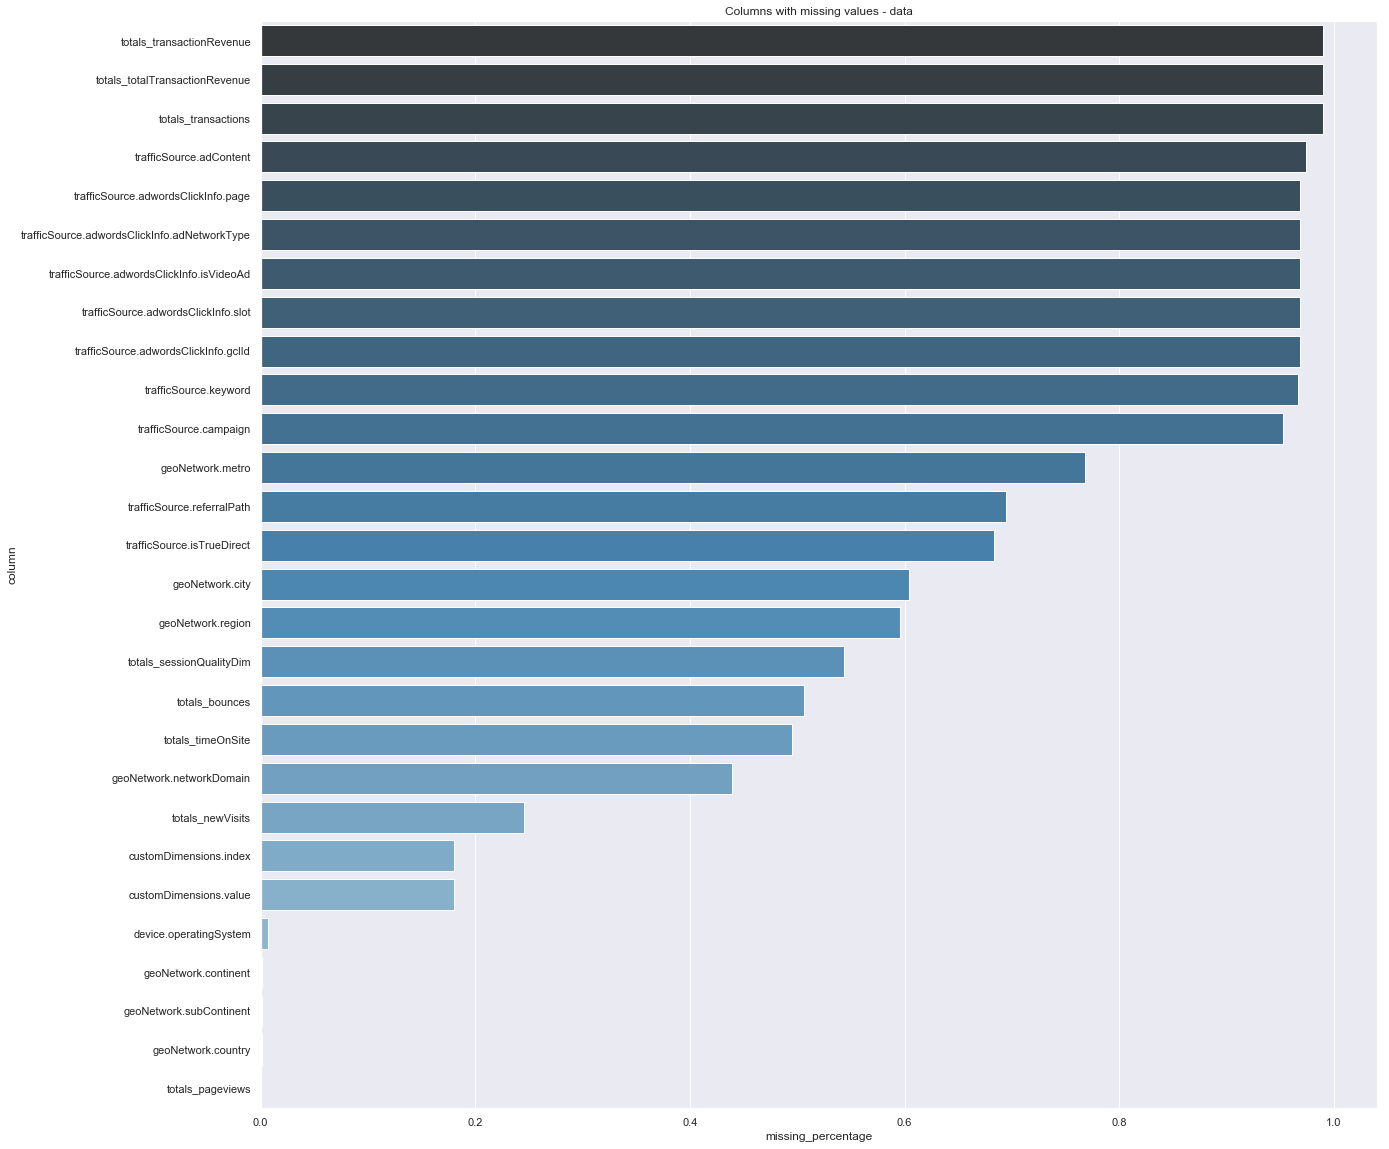

In [17]:
def missing_plot(frame, set_name, palette):
    nan_ratio = frame.isna().sum()/len(frame)
    nan_ratio = nan_ratio.to_frame().reset_index().rename({'index': 'column', 0: 'missing_percentage'},axis=1)
    nan_ratio.sort_values(by=['missing_percentage'], ascending=False, inplace=True)
    plt.figure(figsize=(20,20))
    plt.title("Columns with missing values - {}".format(set_name))
    ax = sns.barplot(x='missing_percentage', y='column', orient='h',
                     data=nan_ratio[nan_ratio['missing_percentage'] > 0],
                     palette= palette)


missing_plot(data, 'data', 'Blues_d')

###### Replacing missing values with 0

In [18]:
data.fillna(0, inplace=True)

In [19]:
data.isnull().sum().sort_values(ascending=False)

customDimensions.value                          0
totals_sessionQualityDim                        0
device.isMobile                                 0
device.deviceCategory                           0
device.browser                                  0
totals_transactions                             0
totals_transactionRevenue                       0
totals_totalTransactionRevenue                  0
totals_timeOnSite                               0
totals_pageviews                                0
geoNetwork.city                                 0
totals_newVisits                                0
totals_hits                                     0
totals_bounces                                  0
visitStartTime                                  0
visitNumber                                     0
visitId                                         0
fullVisitorId                                   0
device.operatingSystem                          0
geoNetwork.continent                            0


###### Total visits vs unique users

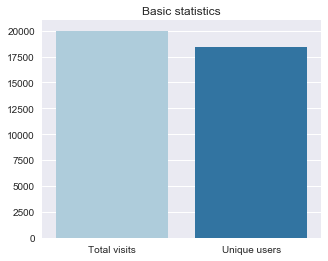

In [30]:
values_name = ['Total visits', 'Unique users']
values = [len(data), data['fullVisitorId'].nunique()]
plt.figure(figsize=(5,4))
plt.title("Basic statistics")
ax = sns.barplot(x=values_name, y=values, palette='Paired')

In [33]:
temp=data.groupby(['fullVisitorId'])['totals_transactionRevenue'].sum()

In [34]:
temp.sort_values(ascending=False).head(20)

fullVisitorId
1814166460229302850    1.171470e+09
7638336411447332495    1.077000e+09
309482894121265066     9.004300e+08
3152246617474456269    6.355000e+08
7168226225550508027    5.939100e+08
3244885836845029978    5.741500e+08
1546626226233851002    5.463200e+08
8092136662808852323    5.368200e+08
4907909077188298193    4.860900e+08
0175318834283875506    4.648000e+08
3746316960999614032    3.977000e+08
1776658355119092313    3.957300e+08
8516473451212465925    3.390300e+08
1710046532262949205    3.389700e+08
5613784133853070022    3.353100e+08
5327166854580374902    3.066700e+08
9228091811246318377    3.054900e+08
1095886019324498043    3.054700e+08
3508419666243874603    3.003500e+08
0750845334721949296    2.987600e+08
Name: totals_transactionRevenue, dtype: float64

### Distribution of transaction revenue

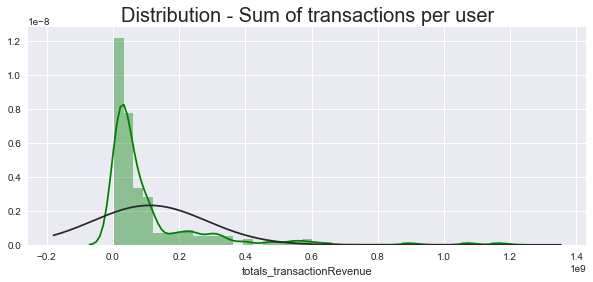

In [35]:
g = data[data['totals_transactionRevenue'] > 0][['fullVisitorId', 'totals_transactionRevenue']]
sum_transactions = g.groupby('fullVisitorId')['totals_transactionRevenue'].sum()
plt.figure(figsize=(10,4))
plt.title("Distribution - Sum of transactions per user",fontsize=20)
ax1 = sns.distplot(sum_transactions, color="green", fit=stats.norm)

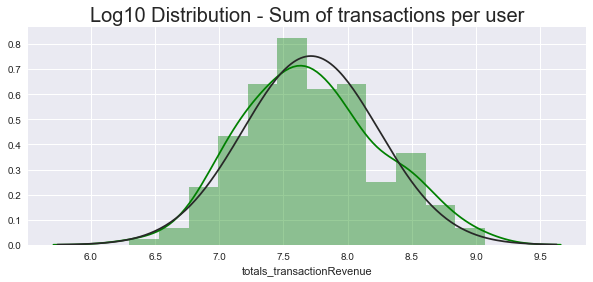

In [36]:
g = data[data['totals_transactionRevenue'] > 0][['fullVisitorId', 'totals_transactionRevenue']]
sum_transactions = g.groupby('fullVisitorId')['totals_transactionRevenue'].sum()
plt.figure(figsize=(10,4))
plt.title("Log10 Distribution - Sum of transactions per user",fontsize=20)
ax1 = sns.distplot(np.log10(sum_transactions), color="green", fit=stats.norm)

Text(0.5,1,'Revenue Value Distribution')

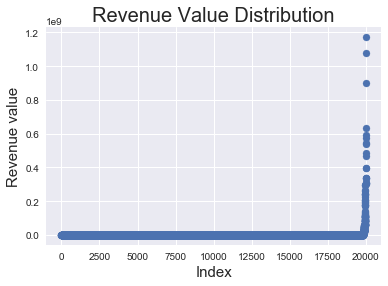

In [39]:
plt.scatter(range(data.shape[0]), np.sort(data['totals_transactionRevenue'].values))
plt.xlabel('Index', fontsize=15)
plt.ylabel('Revenue value', fontsize=15) 
plt.title("Revenue Value Distribution", fontsize=20) 

### Device Browsers

###### the top 10 of browsers represent % of total

In [40]:
print("Browser usage: ")
print(data['device.browser'].value_counts()[:10] ) # printing the top 7 percentage of browsers

Browser usage: 
Chrome               13978
Safari                3340
Firefox                829
Internet Explorer      530
Android Webview        300
Edge                   267
Opera Mini             191
Safari (in-app)        139
Samsung Internet       137
Opera                  134
Name: device.browser, dtype: int64


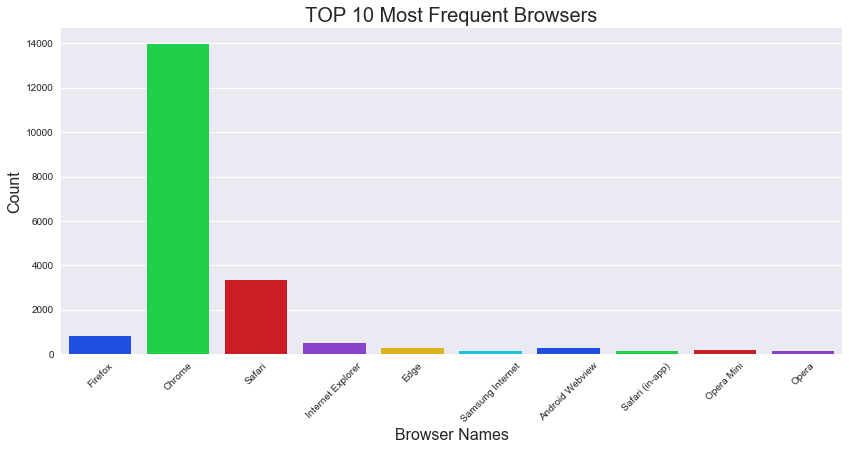

In [41]:
plt.figure(figsize=(14,6))

sns.countplot(data[data['device.browser']\
                       .isin(data['device.browser']\
                             .value_counts()[:10].index.values)]['device.browser'], palette="bright") 
plt.title("TOP 10 Most Frequent Browsers", fontsize=20)
plt.xlabel("Browser Names", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.xticks(rotation=45)

plt.show()

### Transaction revenue by device browser

###### Maximum revenue is getting generated from the top 3 browsers

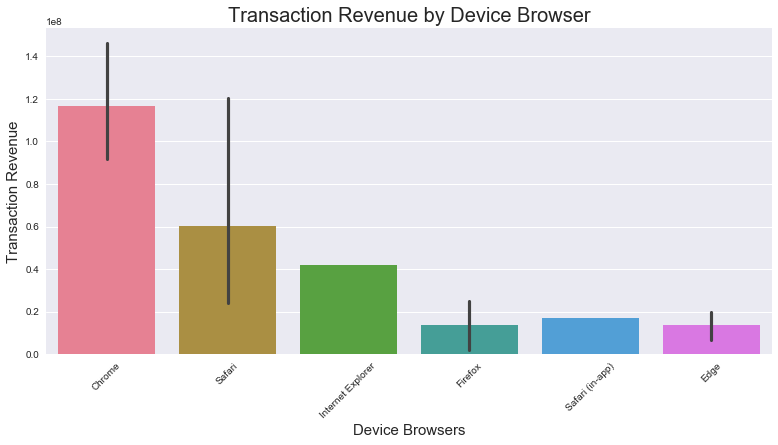

In [42]:
plt.figure(figsize=(13,6)) 

g1 = sns.barplot(x='device.browser', y='totals_transactionRevenue', 
                   data=data[(data['device.browser'].isin((data['device.browser'].value_counts()[:10].index.values))) &
                                  data['totals_transactionRevenue'] > 0],palette='husl')
g1.set_title('Transaction Revenue by Device Browser', fontsize=20) 
g1.set_xlabel('Device Browsers', fontsize=15) 
g1.set_ylabel('Transaction Revenue', fontsize=15) 
plt.xticks(rotation=45)
plt.show()

### Transaction Revenue by Device Types

###### Maximum revenue is generated from the desktop users

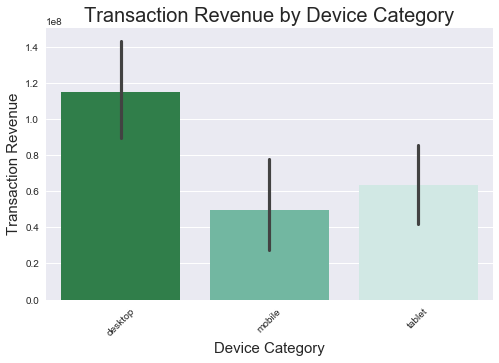

In [91]:
plt.figure(figsize=(8,5))

g1 = sns.barplot(x='device.deviceCategory', y='totals_transactionRevenue', 
                   data=data[(data['device.deviceCategory'].isin((data['device.deviceCategory'].value_counts().index.values))) &
                                  data['totals_transactionRevenue'] > 0],palette='BuGn_r')
g1.set_title('Transaction Revenue by Device Category', fontsize=20)
g1.set_xlabel('Device Category', fontsize=15) 
g1.set_ylabel('Transaction Revenue', fontsize=15) 
plt.xticks(rotation=45)
plt.show()

(array([0, 1]), <a list of 2 Text xticklabel objects>)

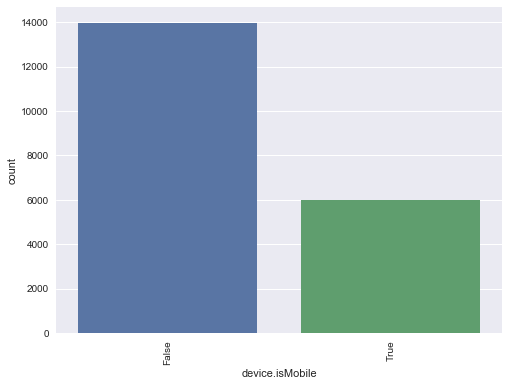

In [71]:
plt.figure(figsize=(8,6))
sns.countplot(data['device.isMobile'])
plt.xticks(rotation=90)

### Channel by which user introduced to store

In [92]:
print("Channel Grouping used: ")
print((data['channelGrouping'].value_counts()))

Channel Grouping used: 
Organic Search    9535
Social            3455
Direct            3047
Referral          2649
Paid Search        527
Affiliates         425
Display            362
Name: channelGrouping, dtype: int64


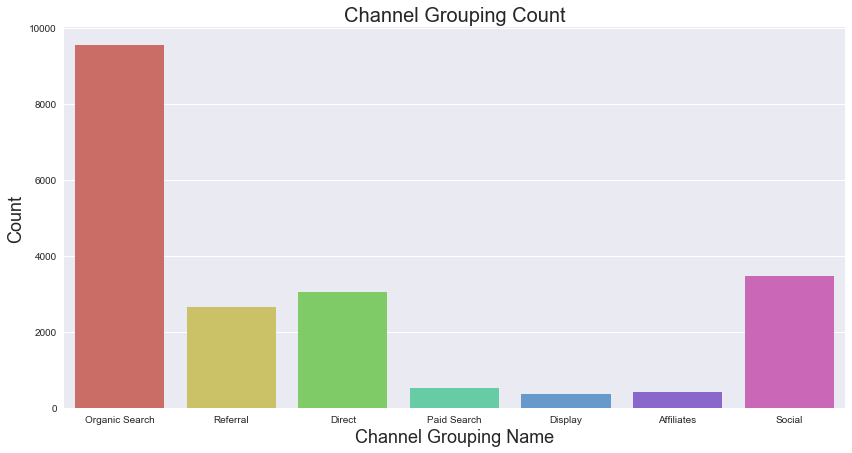

In [93]:
plt.figure(figsize=(14,7))

sns.countplot(data["channelGrouping"], palette="hls") 
plt.title("Channel Grouping Count", fontsize=20) 
plt.xlabel("Channel Grouping Name", fontsize=18) 
plt.ylabel("Count", fontsize=18)

plt.show()

###### Transaction Revenue by Device Operating

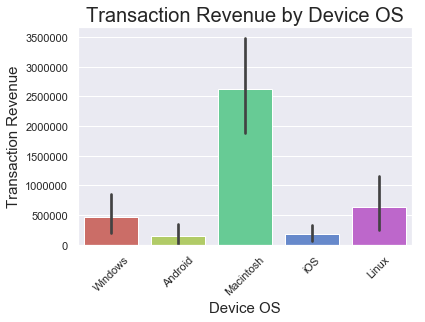

In [32]:
g1 = sns.barplot(x='device.operatingSystem', y='totals_transactionRevenue', 
                   data=data[(data['device.operatingSystem'].isin((data['device.operatingSystem'].value_counts()[:5].index.values)))],palette='hls')
g1.set_title('Transaction Revenue by Device OS', fontsize=20) 
g1.set_xlabel('Device OS', fontsize=15) 
g1.set_ylabel('Transaction Revenue', fontsize=15)
plt.xticks(rotation=45)
plt.show()

### Transaction Revenue by Continent

###### Maximum Revenue is generated from Americas. We will look into the sub-continent wise revenue distribution to get a better understanding.

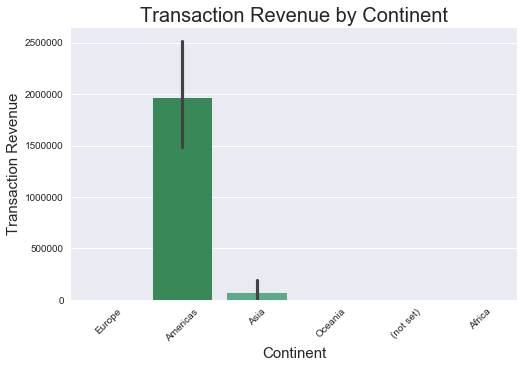

In [94]:
plt.figure(figsize=(8,5))

g1 = sns.barplot(x='geoNetwork.continent', y='totals_transactionRevenue', 
                   data=data[(data['geoNetwork.continent'].isin((data['geoNetwork.continent'].value_counts().index.values))) ],palette='BuGn_r')
g1.set_title('Transaction Revenue by Continent', fontsize=20)
g1.set_xlabel('Continent', fontsize=15) 
g1.set_ylabel('Transaction Revenue', fontsize=15) 
plt.xticks(rotation=45)
plt.show()

In [95]:
# the top 10 sub-continents
print("SubContinent count: ")
print(data['geoNetwork.subContinent'].value_counts()[:10])

SubContinent count: 
Northern America    9287
Western Europe      1460
Northern Europe     1312
Southern Asia       1270
Eastern Asia        1236
Southeast Asia      1084
Eastern Europe       948
South America        842
Southern Europe      791
Western Asia         639
Name: geoNetwork.subContinent, dtype: int64


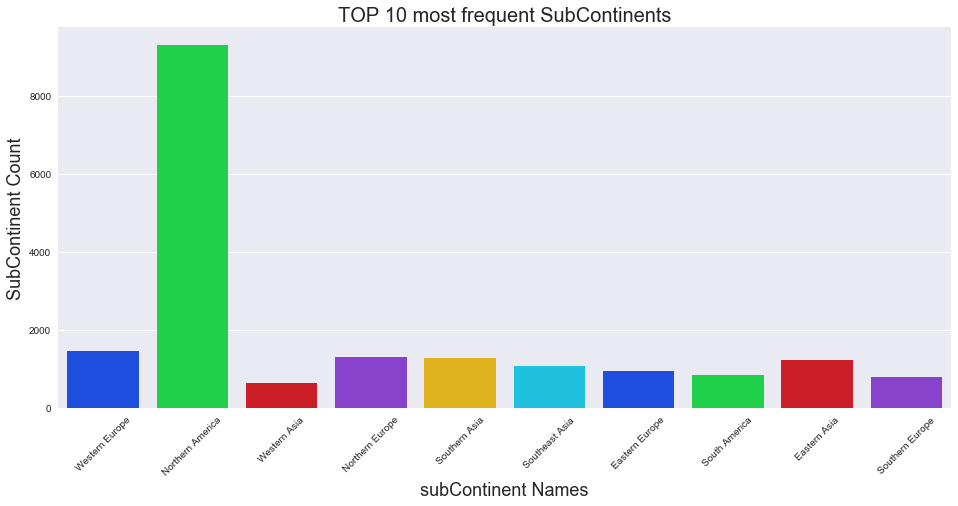

In [37]:
plt.figure(figsize=(16,7))

sns.countplot(data[data['geoNetwork.subContinent']\
                       .isin(data['geoNetwork.subContinent']\
                             .value_counts()[:10].index.values)]['geoNetwork.subContinent'], palette="bright") 
plt.title("TOP 10 most frequent SubContinents", fontsize=20) 
plt.xlabel("subContinent Names", fontsize=18) 
plt.ylabel("SubContinent Count", fontsize=18)
plt.xticks(rotation=45)

plt.show()



Pie Chart geoNetwork.continent


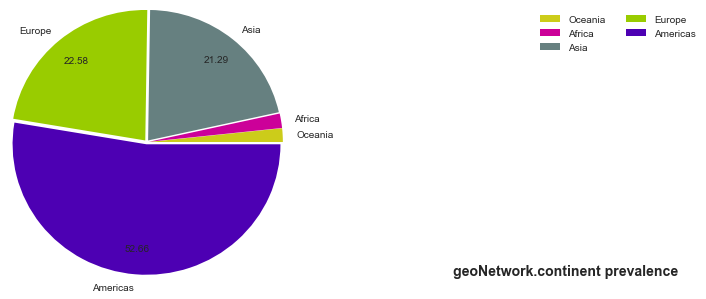

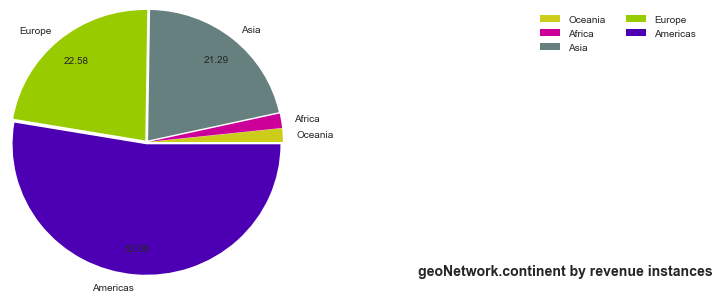

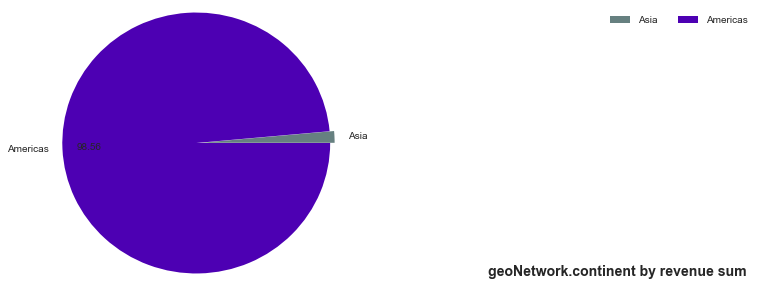

In [86]:
make_revenue_pie(data, 'geoNetwork.continent', unique=1000, threshold=100, angle=0)

###### visits by country

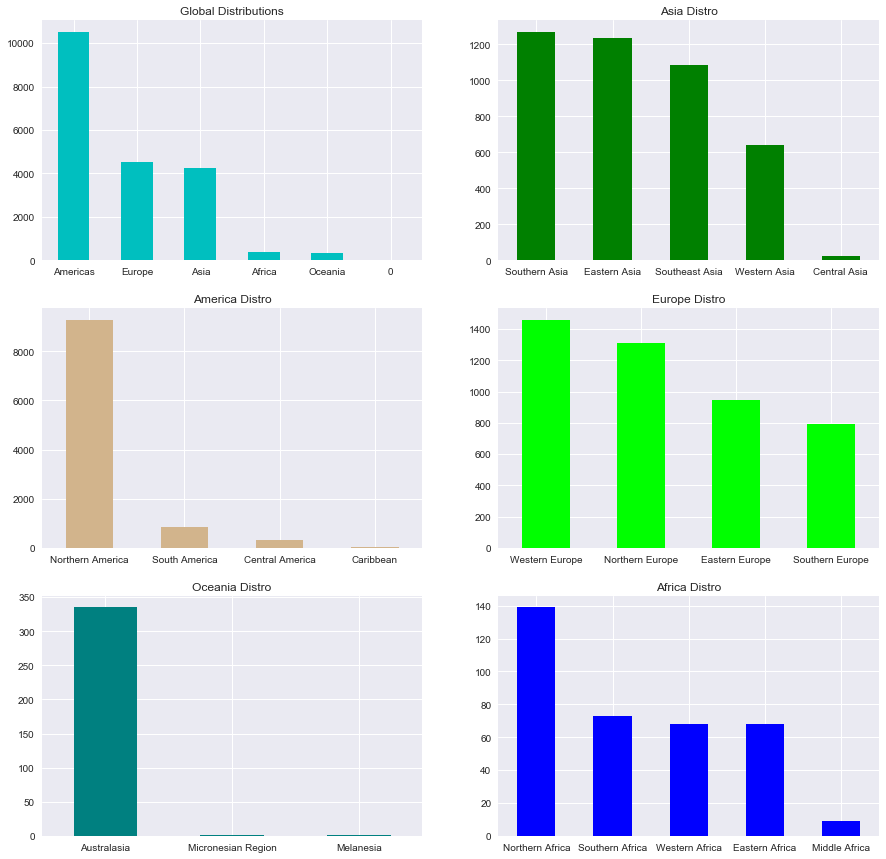

In [65]:
fig, axes = plt.subplots(3,2, figsize=(15,15))
data["geoNetwork.continent"].value_counts().plot(kind="bar",ax=axes[0][0],title="Global Distributions",rot=0,color="c")
data[data["geoNetwork.continent"] == "Americas"]["geoNetwork.subContinent"].value_counts().plot(kind="bar",ax=axes[1][0], title="America Distro",rot=0,color="tan")
data[data["geoNetwork.continent"] == "Asia"]["geoNetwork.subContinent"].value_counts().plot(kind="bar",ax=axes[0][1], title="Asia Distro",rot=0,color="green")
data[data["geoNetwork.continent"] == "Europe"]["geoNetwork.subContinent"].value_counts().plot(kind="bar",ax=axes[1][1],  title="Europe Distro",rot=0,color="lime")
data[data["geoNetwork.continent"] == "Oceania"]["geoNetwork.subContinent"].value_counts().plot(kind="bar",ax = axes[2][0], title="Oceania Distro",rot=0,color="teal")
data[data["geoNetwork.continent"] == "Africa"]["geoNetwork.subContinent"].value_counts().plot(kind="bar" , ax=axes[2][1], title="Africa Distro",rot=0,color="blue")

In [44]:
data['customDimensions.value'].unique()

array(['EMEA', 'North America', 'Central America', 0, 'APAC',
       'South America'], dtype=object)

In [48]:
temp=data.groupby(['customDimensions.value'])['totals_transactionRevenue'].sum()
temp

customDimensions.value
0                  3.525300e+08
APAC               1.964200e+08
Central America    0.000000e+00
EMEA               0.000000e+00
North America      2.044243e+10
South America      0.000000e+00
Name: totals_transactionRevenue, dtype: float64

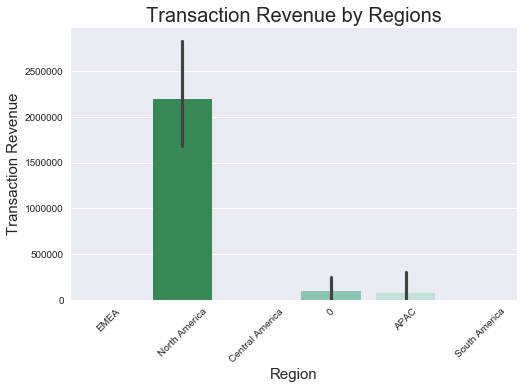

In [51]:
plt.figure(figsize=(8,5))

g1 = sns.barplot(x='customDimensions.value', y='totals_transactionRevenue', 
                   data=data[(data['customDimensions.value'].isin((data['customDimensions.value'].value_counts().index.values))) ],palette='BuGn_r')
g1.set_title('Transaction Revenue by Regions', fontsize=20) 
g1.set_xlabel('Region', fontsize=15) 
g1.set_ylabel('Transaction Revenue', fontsize=15) 
plt.xticks(rotation=45)
plt.show()

###### Revenue by date

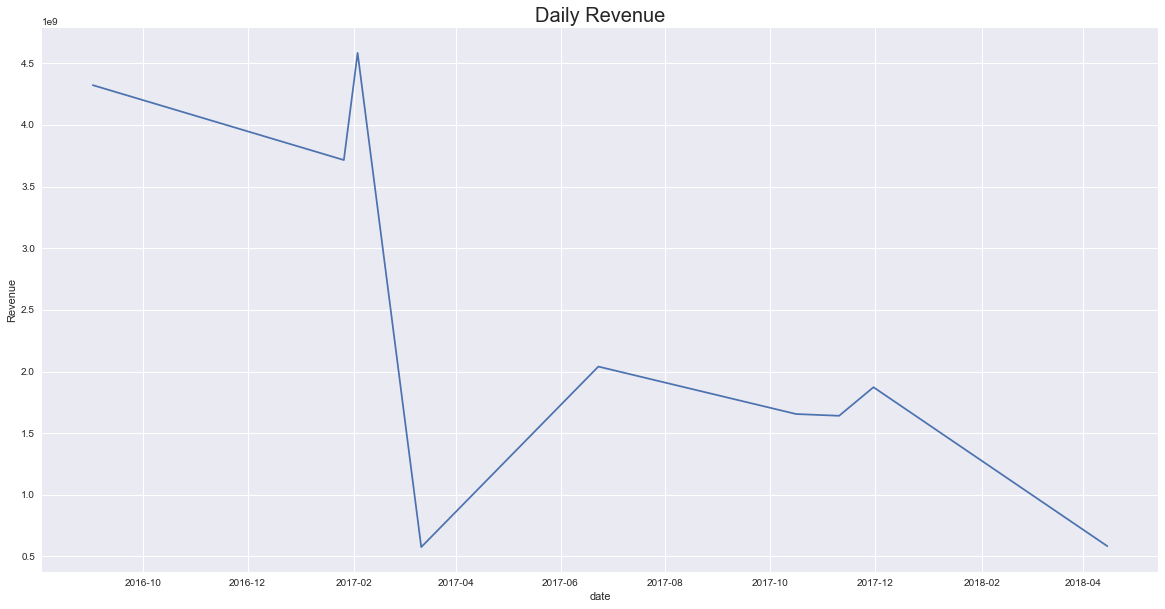

In [52]:
daily_revenue_df = data.groupby(by=["date"],axis = 0 ).sum()
fig, axes = plt.subplots(figsize=(20,10))
axes.set_title("Daily Revenue", fontsize=20)
axes.set_ylabel("Revenue")
axes.set_xlabel("date")
axes.plot(daily_revenue_df["totals_transactionRevenue"])

###### Visits by date

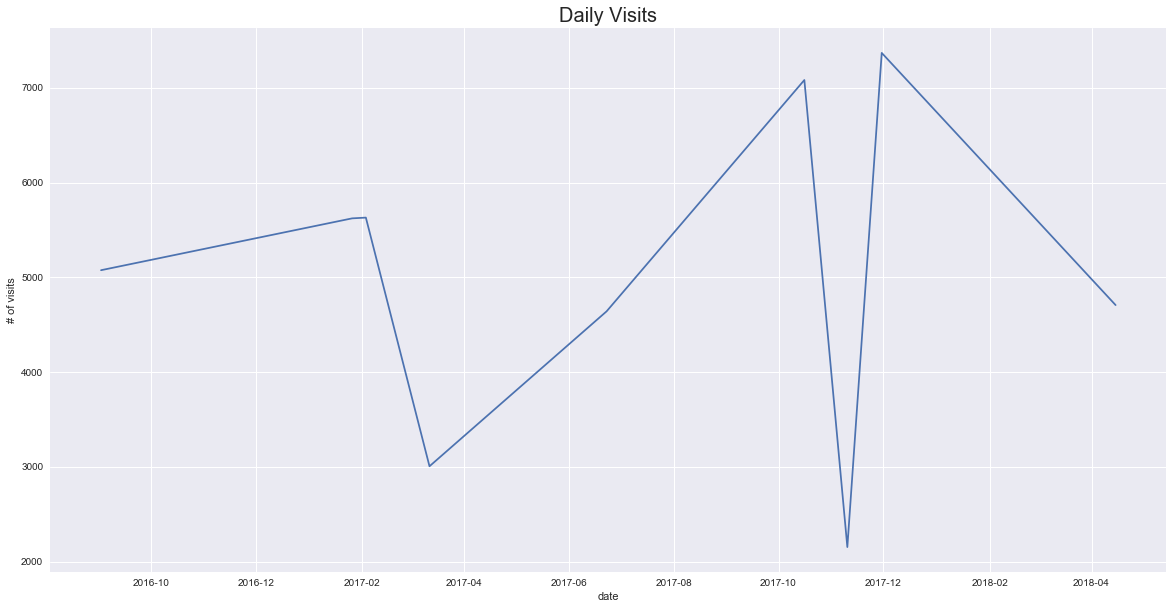

In [56]:
daily_visit_df = data.groupby(by=["date"], axis = 0).sum()

fig, axes = plt.subplots(1,1,figsize=(20,10))
axes.set_ylabel("# of visits")
axes.set_xlabel("date")
axes.set_title("Daily Visits", fontsize=20)
axes.plot(daily_visit_df["visitNumber"])

In [52]:
data['_visitHour'] = (data['visitStartTime'].apply(lambda x: str(datetime.fromtimestamp(x).hour))).astype(int)
temp=data.groupby(['_visitHour'])['totals_transactionRevenue'].sum()


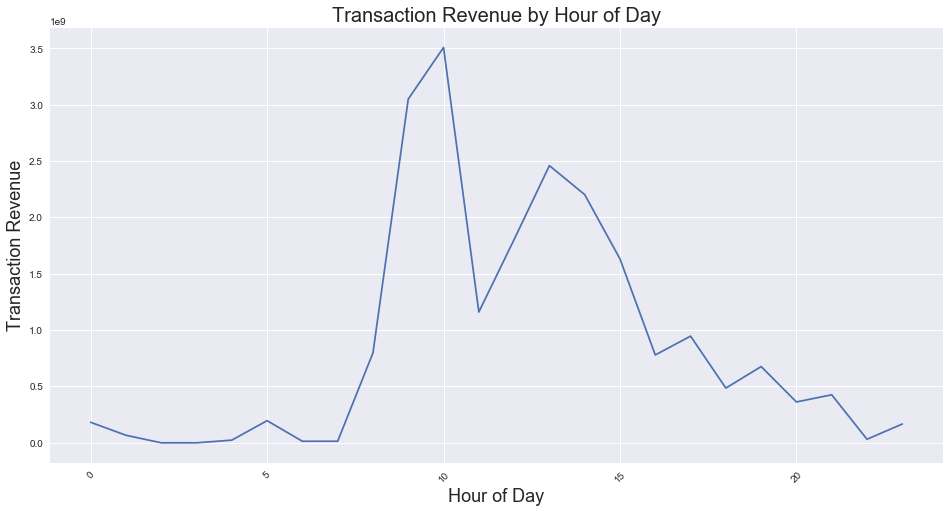

In [53]:
plt.figure(figsize=(16,8))
plt.plot(temp)
plt.title("Transaction Revenue by Hour of Day", fontsize=20)
plt.xlabel("Hour of Day", fontsize=18)
plt.ylabel("Transaction Revenue", fontsize=18)
plt.xticks(rotation=45) 

plt.show()

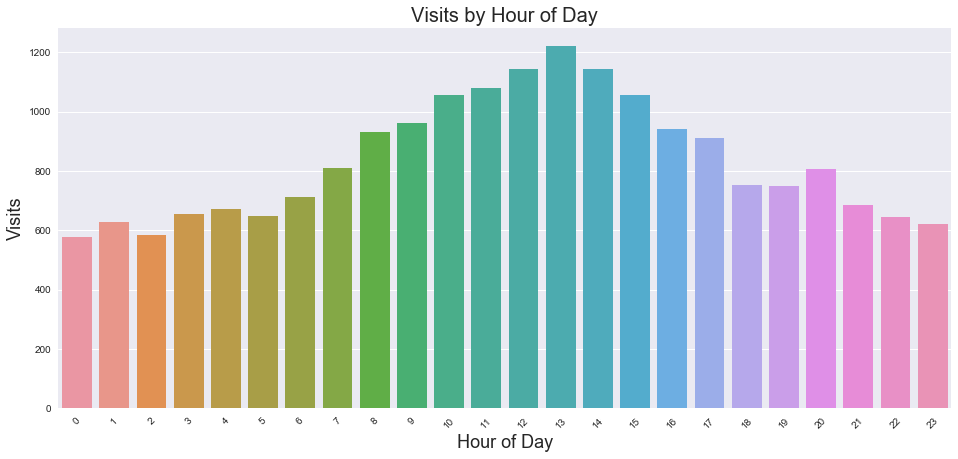

In [54]:
plt.figure(figsize=(16,7))
sns.countplot(data[data['_visitHour']\
                       .isin(data['_visitHour']\
                             .value_counts().index.values)]['_visitHour'])
plt.title("Visits by Hour of Day", fontsize=20) 
plt.xlabel("Hour of Day", fontsize=18) 
plt.ylabel("Visits", fontsize=18)
plt.xticks(rotation=45) 

plt.show()

###### visit number distribution

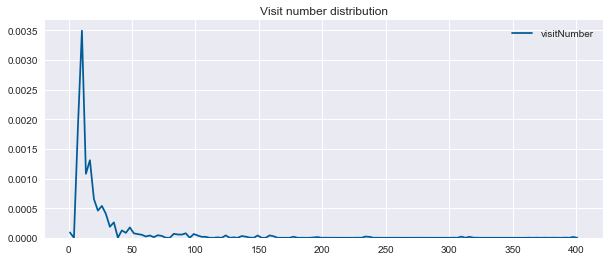

In [32]:
plt.figure(figsize=(10,4))
plt.title("Visit number distribution")
ax1 = sns.kdeplot(data['visitNumber'], color="#005c99")

###### Revenue per visits

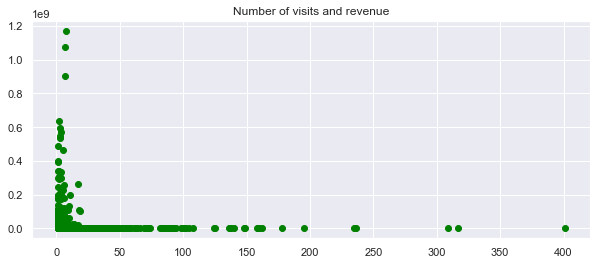

In [48]:
plt.figure(figsize=(10,4))
plt.title("Number of visits and revenue")
ax = plt.scatter(x='visitNumber', y='totals_transactionRevenue',
                     data=data,color='green') 

###### Bounces

Revenue for bounce missing: 0.0, revenue for bounce '1': 20991380000.0


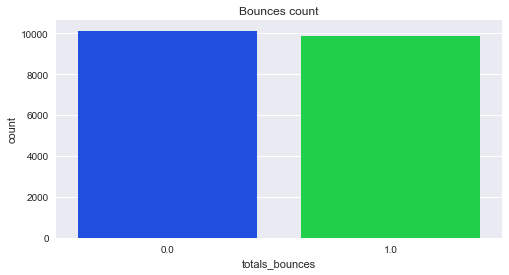

In [64]:
bounces_nan = data[data['totals_bounces'].isnull()]['totals_transactionRevenue'].sum()
bounces_1 = data[~data['totals_bounces'].isnull()]['totals_transactionRevenue'].sum()
print("Revenue for bounce missing: {}, revenue for bounce '1': {}".format(bounces_nan, bounces_1))
plt.figure(figsize=(8,4))
plt.title("Bounces count")
ax = sns.countplot(x='totals_bounces', data=data.fillna('nan'),palette='bright')

###### New Visits

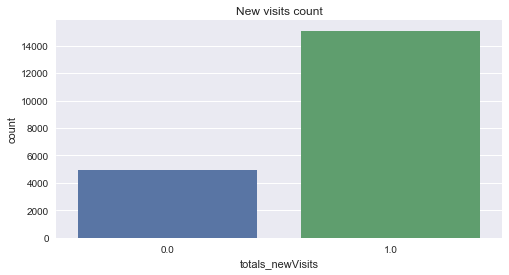

In [49]:
plt.figure(figsize=(8,4))
plt.title("New visits count")
ax = sns.countplot(x='totals_newVisits', data=data.fillna('nan'))

###### Hits Distribution

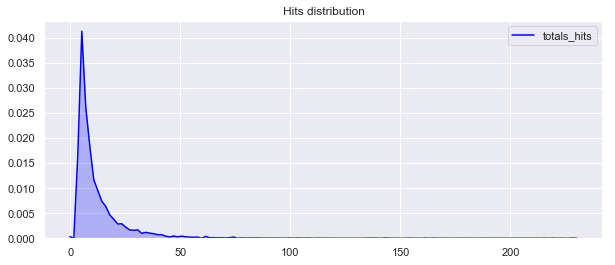

In [45]:
plt.figure(figsize=(10,4))
plt.title("Hits distribution")
ax1 = sns.kdeplot(data['totals_hits'].astype('float64'), color="blue", shade=True)


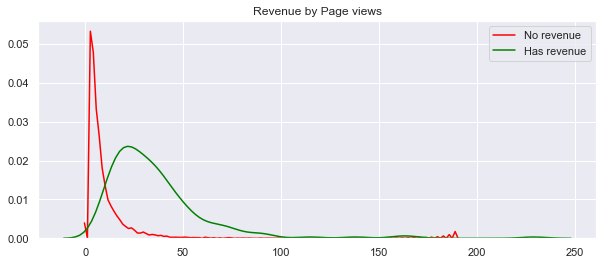

In [44]:
plt.figure(figsize=(10,4))
plt.title("Revenue by Page views")
ax2 = sns.kdeplot(data[data['totals_transactionRevenue'] == 0]['totals_hits'].astype('float64'),
                  label='No revenue', color="red")
ax2 = sns.kdeplot(data[data['totals_transactionRevenue'] > 0]['totals_hits'].astype('float64'),
                  label='Has revenue', color="green")

###### Hits vs log Revenue

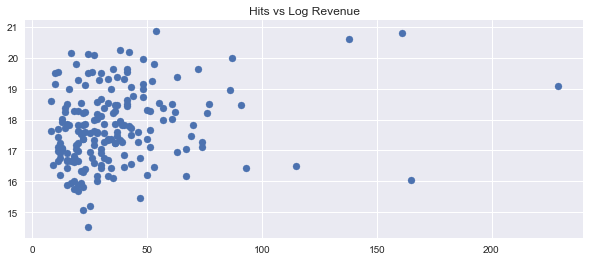

In [66]:
plt.figure(figsize=(10,4))
plt.title("Hits vs Log Revenue")
ax = plt.scatter(x=data['totals_hits'].astype('float64'), y=np.log(data['totals_transactionRevenue']))

###### Hits vs Page views

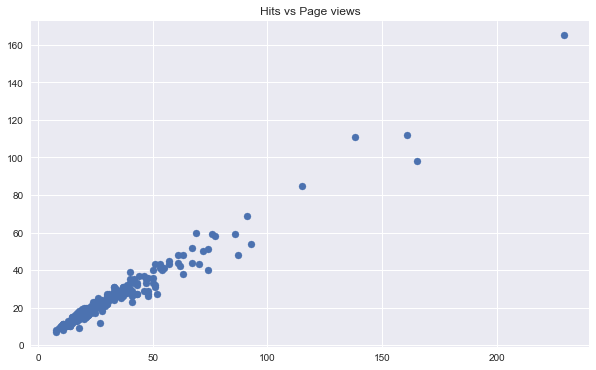

In [86]:
plt.figure(figsize=(10,6))
plt.title("Hits vs Page views")
temp=data[data['totals_transactionRevenue']>0]
tmp = temp[['totals_hits', 'totals_pageviews', 'totals_transactionRevenue']].copy()
tmp['totals_hits'] = tmp['totals_hits'].astype('float64')
tmp['totals_pageviews'] = tmp['totals_pageviews'].dropna().astype('float64')
ax = plt.scatter(x='totals_hits', y='totals_pageviews', data=tmp)



Pie Chart totals_bounces


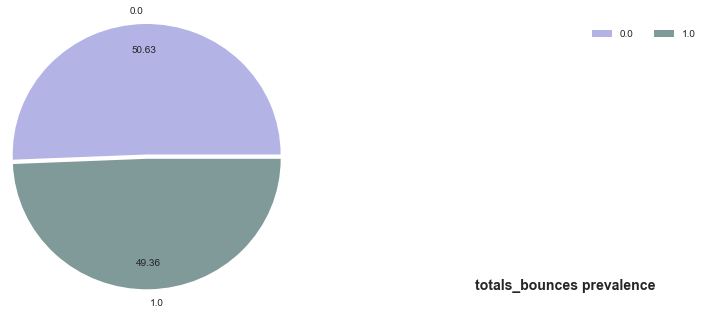

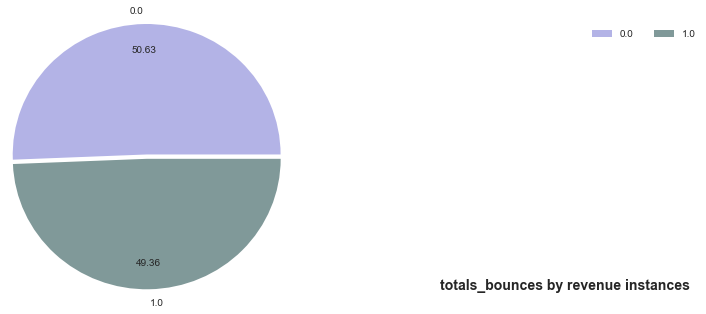

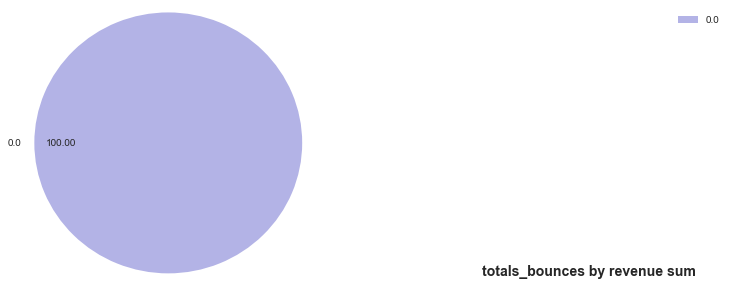

In [88]:
make_revenue_pie(data, 'totals_bounces', unique=1000, threshold=100, angle=0, sorty=False)

###### Totals per user

### Feature Scaling/Engineering

###### Skewness and kurtosis check of distribution

###### The value of skewness and kurtosis shows the data is skewed

In [104]:
print('Excess kurtosis of normal distribution (should be 0): {}'.format(
    kurtosis(data[data['totals_transactionRevenue'] > 0]["totals_transactionRevenue"])))
print( 'Skewness of normal distribution (should be 0): {}'.format(
    skew((data[data['totals_transactionRevenue'] > 0]["totals_transactionRevenue"]))))

Excess kurtosis of normal distribution (should be 0): 14.509570787850308
Skewness of normal distribution (should be 0): 3.441773157139581


###### Categorical Data

In [19]:
cat_cols = ["channelGrouping", "device.browser", 
            "device.deviceCategory", "device.operatingSystem", 
            "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", 
            "geoNetwork.subContinent", "trafficSource.adContent", 
            "trafficSource.adwordsClickInfo.adNetworkType", 
            "trafficSource.adwordsClickInfo.gclId", 
            "trafficSource.adwordsClickInfo.page", 
            "trafficSource.adwordsClickInfo.slot", "trafficSource.campaign",
            "trafficSource.keyword", "trafficSource.medium", 
            "trafficSource.referralPath", "trafficSource.source",
            'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.isTrueDirect','customDimensions.value']
for col in cat_cols:
    print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(data[col].values.astype('str')))
    data[col] = lbl.transform(list(data[col].values.astype('str')))

channelGrouping
device.browser
device.deviceCategory
device.operatingSystem
geoNetwork.city
geoNetwork.continent
geoNetwork.country
geoNetwork.metro
geoNetwork.networkDomain
geoNetwork.region
geoNetwork.subContinent
trafficSource.adContent
trafficSource.adwordsClickInfo.adNetworkType
trafficSource.adwordsClickInfo.gclId
trafficSource.adwordsClickInfo.page
trafficSource.adwordsClickInfo.slot
trafficSource.campaign
trafficSource.keyword
trafficSource.medium
trafficSource.referralPath
trafficSource.source
trafficSource.adwordsClickInfo.isVideoAd
trafficSource.isTrueDirect
customDimensions.value


###### Numerical Data

In [20]:
num_cols = ["totals_hits", "totals_pageviews", "visitNumber", "visitStartTime", 'totals_bounces',  'totals_newVisits']    
for col in num_cols:
    data[col] = data[col].astype(float)

In [20]:
print("Printout for each column's number of unique values (incl. nans)\n")
for col in data.columns:
    try:
        print(col)
    except TypeError:
        a=data[col].astype('str')
        print( col)
# Clean workspace
del(col)

Printout for each column's number of unique values (incl. nans)

channelGrouping
fullVisitorId
visitId
visitNumber
visitStartTime
totals_bounces
totals_hits
totals_newVisits
totals_pageviews
totals_sessionQualityDim
totals_timeOnSite
totals_totalTransactionRevenue
totals_transactionRevenue
totals_transactions
device.browser
device.deviceCategory
device.isMobile
device.operatingSystem
geoNetwork.city
geoNetwork.continent
geoNetwork.country
geoNetwork.metro
geoNetwork.networkDomain
geoNetwork.region
geoNetwork.subContinent
trafficSource.adContent
trafficSource.adwordsClickInfo.adNetworkType
trafficSource.adwordsClickInfo.gclId
trafficSource.adwordsClickInfo.isVideoAd
trafficSource.adwordsClickInfo.page
trafficSource.adwordsClickInfo.slot
trafficSource.campaign
trafficSource.isTrueDirect
trafficSource.keyword
trafficSource.medium
trafficSource.referralPath
trafficSource.source
customDimensions.index
customDimensions.value


In [21]:
data.drop('fullVisitorId', axis=1, inplace=True)

In [22]:
data.drop('totals_totalTransactionRevenue', axis=1, inplace=True)

In [23]:
data.drop('visitId', axis=1, inplace=True)

In [24]:
data.drop('visitStartTime', axis=1, inplace=True)

In [25]:
print("Printout for each column's number of unique values (incl. nans)\n")
for col in data.columns:
    try:
        print(col)
    except TypeError:
        a=data[col].astype('str')
        print( col)
# Clean workspace
del(col)

Printout for each column's number of unique values (incl. nans)

channelGrouping
visitNumber
totals_bounces
totals_hits
totals_newVisits
totals_pageviews
totals_sessionQualityDim
totals_timeOnSite
totals_transactionRevenue
totals_transactions
device.browser
device.deviceCategory
device.isMobile
device.operatingSystem
geoNetwork.city
geoNetwork.continent
geoNetwork.country
geoNetwork.metro
geoNetwork.networkDomain
geoNetwork.region
geoNetwork.subContinent
trafficSource.adContent
trafficSource.adwordsClickInfo.adNetworkType
trafficSource.adwordsClickInfo.gclId
trafficSource.adwordsClickInfo.isVideoAd
trafficSource.adwordsClickInfo.page
trafficSource.adwordsClickInfo.slot
trafficSource.campaign
trafficSource.isTrueDirect
trafficSource.keyword
trafficSource.medium
trafficSource.referralPath
trafficSource.source
customDimensions.index
customDimensions.value


###### Checking correlation among the columns

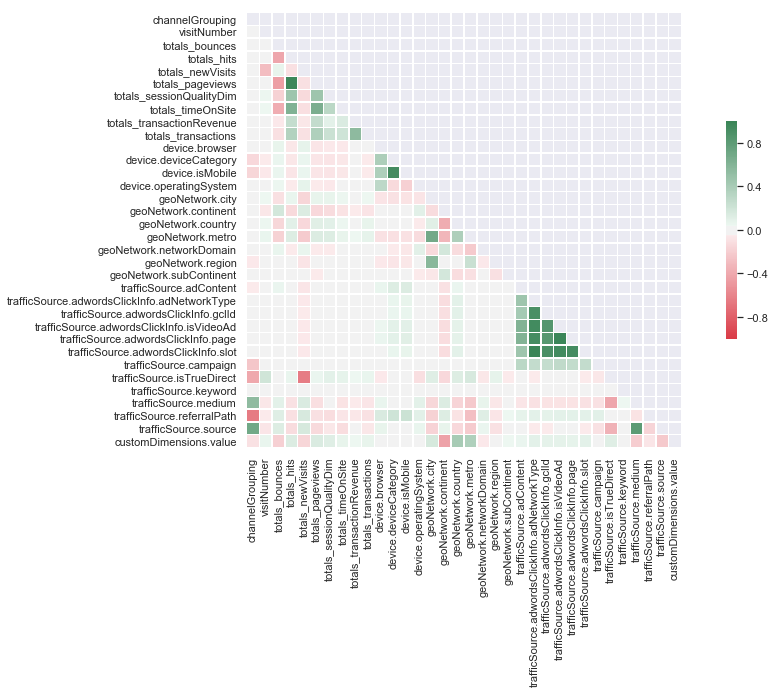

In [22]:
plot_corr_heatmap(data.corr())

###### Removing highly correlated columns

In [26]:
data.drop(['trafficSource.isTrueDirect','trafficSource.referralPath','totals_hits','totals_sessionQualityDim', 'totals_timeOnSite','device.isMobile','trafficSource.adContent',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.isVideoAd',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
       'trafficSource.isTrueDirect', 'trafficSource.keyword','trafficSource.keyword',
       'trafficSource.medium'],axis=1, inplace=True)

###### Taking logarithm transformation of totals_transactionRevenue to normalize the data as the distribution is highly skewed

In [27]:
y=np.log1p(data["totals_transactionRevenue"])
X=data.drop("totals_transactionRevenue",axis=1)

In [25]:
X.columns

Index(['channelGrouping', 'visitNumber', 'totals_bounces', 'totals_newVisits',
       'totals_pageviews', 'totals_transactions', 'device.browser',
       'device.deviceCategory', 'device.operatingSystem', 'geoNetwork.city',
       'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'trafficSource.source',
       'customDimensions.index', 'customDimensions.value'],
      dtype='object')

In [28]:
X_train_org, X_test_org, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=0)

###### StandardScaler removes the mean and scales the data to unit variance. This scaler cannot guarantee balanced feature scales in the presence of outliers. MinMaxScaler rescales the data set such that all feature values are in the range [0, 1]. The outliers have an influence when computing the empirical mean and standard deviation which shrink the range of the feature values. Therefore, we prefer using MinMaxScaler to preserve the effects of outliers.

###### Using minmax scaler for the columns as values are very large

In [29]:
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train_org)
X_test = sc.transform(X_test_org)

### Supervised Models

###### Using gridsearch to find best parameters

### Gradient Boosting Regressor

###### Initial parameter values (will be tuned using grid search cv): learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=6,max_features='sqrt',subsample=0.8,random_state=10), param_grid_gb, cv=5, return_train_score=True

In [90]:
param_grid_gb = {
'n_estimators' : [20,50,80,100],
                  }

print("Parameter grid:\n{}".format(param_grid_gb))

grid_search_gb = GridSearchCV(GradientBoostingRegressor(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=6,max_features='sqrt',subsample=0.8,random_state=10), param_grid_gb, cv=5, return_train_score=True)
grid_search_gb.fit(X_train,y_train)



Parameter grid:
{'n_estimators': [20, 50, 80, 100]}


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=6,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=50, min_samples_split=500,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=10, subsample=0.8, verbose=0,
             warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [20, 50, 80, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [91]:
grid_search_gb.grid_scores_, grid_search_gb.best_params_, grid_search_gb.best_score_

([mean: 0.76219, std: 0.03561, params: {'n_estimators': 20},
  mean: 0.92639, std: 0.02528, params: {'n_estimators': 50},
  mean: 0.95897, std: 0.02886, params: {'n_estimators': 80},
  mean: 0.96218, std: 0.02897, params: {'n_estimators': 100}],
 {'n_estimators': 100},
 0.9621792847508485)

In [92]:
param_grid_gb = {
'max_depth' : [3,7,10,15],
'min_samples_split': [100,300,500],
                  }

print("Parameter grid:\n{}".format(param_grid_gb))

grid_search_gb2 = GridSearchCV(GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_features='sqrt', subsample=0.8, random_state=10), param_grid_gb, cv=5, return_train_score=True)
grid_search_gb2.fit(X_train,y_train)



Parameter grid:
{'max_depth': [3, 7, 10, 15], 'min_samples_split': [100, 300, 500]}


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=10, subsample=0.8, verbose=0,
             warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, 7, 10, 15], 'min_samples_split': [100, 300, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [93]:
grid_search_gb2.grid_scores_, grid_search_gb2.best_params_, grid_search_gb2.best_score_

([mean: 0.96912, std: 0.02525, params: {'max_depth': 3, 'min_samples_split': 100},
  mean: 0.96467, std: 0.02362, params: {'max_depth': 3, 'min_samples_split': 300},
  mean: 0.96557, std: 0.02353, params: {'max_depth': 3, 'min_samples_split': 500},
  mean: 0.96846, std: 0.02318, params: {'max_depth': 7, 'min_samples_split': 100},
  mean: 0.96341, std: 0.02807, params: {'max_depth': 7, 'min_samples_split': 300},
  mean: 0.96504, std: 0.02708, params: {'max_depth': 7, 'min_samples_split': 500},
  mean: 0.96852, std: 0.03081, params: {'max_depth': 10, 'min_samples_split': 100},
  mean: 0.96697, std: 0.02493, params: {'max_depth': 10, 'min_samples_split': 300},
  mean: 0.96567, std: 0.02399, params: {'max_depth': 10, 'min_samples_split': 500},
  mean: 0.96839, std: 0.02669, params: {'max_depth': 15, 'min_samples_split': 100},
  mean: 0.96428, std: 0.02612, params: {'max_depth': 15, 'min_samples_split': 300},
  mean: 0.96603, std: 0.02420, params: {'max_depth': 15, 'min_samples_split': 500}

In [96]:
param_grid_gb = {
'min_samples_split': [50,100,500],
'min_samples_leaf': [20,30,50]
                  }

print("Parameter grid:\n{}".format(param_grid_gb))

grid_search_gb3 = GridSearchCV(GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_features='sqrt', subsample=0.8,max_depth= 3, random_state=10), param_grid_gb, cv=5, return_train_score=True)
grid_search_gb3.fit(X_train,y_train)


Parameter grid:
{'min_samples_split': [50, 100, 500], 'min_samples_leaf': [20, 30, 50]}


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=10, subsample=0.8, verbose=0,
             warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [50, 100, 500], 'min_samples_leaf': [20, 30, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [97]:
grid_search_gb3.grid_scores_, grid_search_gb3.best_params_, grid_search_gb3.best_score_

([mean: 0.96970, std: 0.02945, params: {'min_samples_leaf': 20, 'min_samples_split': 50},
  mean: 0.96737, std: 0.02719, params: {'min_samples_leaf': 20, 'min_samples_split': 100},
  mean: 0.96242, std: 0.02746, params: {'min_samples_leaf': 20, 'min_samples_split': 500},
  mean: 0.96614, std: 0.03052, params: {'min_samples_leaf': 30, 'min_samples_split': 50},
  mean: 0.96564, std: 0.02902, params: {'min_samples_leaf': 30, 'min_samples_split': 100},
  mean: 0.96236, std: 0.02698, params: {'min_samples_leaf': 30, 'min_samples_split': 500},
  mean: 0.96882, std: 0.02662, params: {'min_samples_leaf': 50, 'min_samples_split': 50},
  mean: 0.96882, std: 0.02662, params: {'min_samples_leaf': 50, 'min_samples_split': 100},
  mean: 0.96729, std: 0.02646, params: {'min_samples_leaf': 50, 'min_samples_split': 500}],
 {'min_samples_leaf': 20, 'min_samples_split': 50},
 0.9696980704849673)

In [98]:
param_grid_gb = {
'max_features':[5,10,15,'sqrt','log2','auto']
                  }

print("Parameter grid:\n{}".format(param_grid_gb))

grid_search_gb4 = GridSearchCV(GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, subsample=0.8,max_depth= 3,min_samples_leaf=20,min_samples_split=50, random_state=10), param_grid_gb, cv=5, return_train_score=True)
grid_search_gb4.fit(X_train,y_train)


Parameter grid:
{'max_features': [5, 10, 15, 'sqrt', 'log2', 'auto']}


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=20,
             min_samples_split=50, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=10,
             subsample=0.8, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': [5, 10, 15, 'sqrt', 'log2', 'auto']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [99]:
grid_search_gb4.grid_scores_, grid_search_gb4.best_params_, grid_search_gb4.best_score_

([mean: 0.97295, std: 0.02937, params: {'max_features': 5},
  mean: 0.97483, std: 0.03046, params: {'max_features': 10},
  mean: 0.97752, std: 0.03042, params: {'max_features': 15},
  mean: 0.96970, std: 0.02945, params: {'max_features': 'sqrt'},
  mean: 0.96970, std: 0.02945, params: {'max_features': 'log2'},
  mean: 0.97865, std: 0.02945, params: {'max_features': 'auto'}],
 {'max_features': 'auto'},
 0.9786518912707534)

In [100]:
param_grid_gb = {
'subsample':[0.6,0.7,0.8,0.9]
                  }

print("Parameter grid:\n{}".format(param_grid_gb))

grid_search_gb5 = GridSearchCV(GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth= 3,min_samples_leaf=20,min_samples_split=50, max_features='auto',random_state=10), param_grid_gb, cv=5, return_train_score=True)
grid_search_gb5.fit(X_train,y_train)


Parameter grid:
{'subsample': [0.6, 0.7, 0.8, 0.9]}


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=20, min_samples_split=50,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=10, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'subsample': [0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [101]:
grid_search_gb5.grid_scores_, grid_search_gb5.best_params_, grid_search_gb5.best_score_

([mean: 0.97855, std: 0.02979, params: {'subsample': 0.6},
  mean: 0.97827, std: 0.02987, params: {'subsample': 0.7},
  mean: 0.97865, std: 0.02945, params: {'subsample': 0.8},
  mean: 0.97887, std: 0.02960, params: {'subsample': 0.9}],
 {'subsample': 0.9},
 0.9788669015481761)

In [102]:
param_grid_gb = {
'learning_rate':[0.05,0.1,0.2]  }

print("Parameter grid:\n{}".format(param_grid_gb))

grid_search_gb6 = GridSearchCV(GradientBoostingRegressor(n_estimators=100, subsample=0.9,max_depth= 3,min_samples_leaf=20,min_samples_split=50,max_features='auto', random_state=10), param_grid_gb, cv=5, return_train_score=True)
grid_search_gb6.fit(X_train,y_train)
#y_test_gb = grid_search_gb.predict(X_test)

Parameter grid:
{'learning_rate': [0.05, 0.1, 0.2]}


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=20, min_samples_split=50,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=10, subsample=0.9, verbose=0,
             warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.05, 0.1, 0.2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [103]:
grid_search_gb6.grid_scores_, grid_search_gb6.best_params_, grid_search_gb6.best_score_

([mean: 0.98011, std: 0.02923, params: {'learning_rate': 0.05},
  mean: 0.97887, std: 0.02960, params: {'learning_rate': 0.1},
  mean: 0.97666, std: 0.02889, params: {'learning_rate': 0.2}],
 {'learning_rate': 0.05},
 0.9801111595531854)

###### Fit the model with optimum parameters selected

In [147]:
gbrt=GradientBoostingRegressor(learning_rate=0.05, n_estimators=100, subsample=0.9,max_depth= 3,min_samples_leaf=20,min_samples_split=50,max_features='auto', random_state=10)
 
gbrt.fit(X_train, y_train) 

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=3,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=20, min_samples_split=50,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=10, subsample=0.9, verbose=0,
             warm_start=False)

In [148]:
gbrt.train_score_ 
gbrt.loss_
gbrt.score(X_train, y_train) 



0.9866914230818954

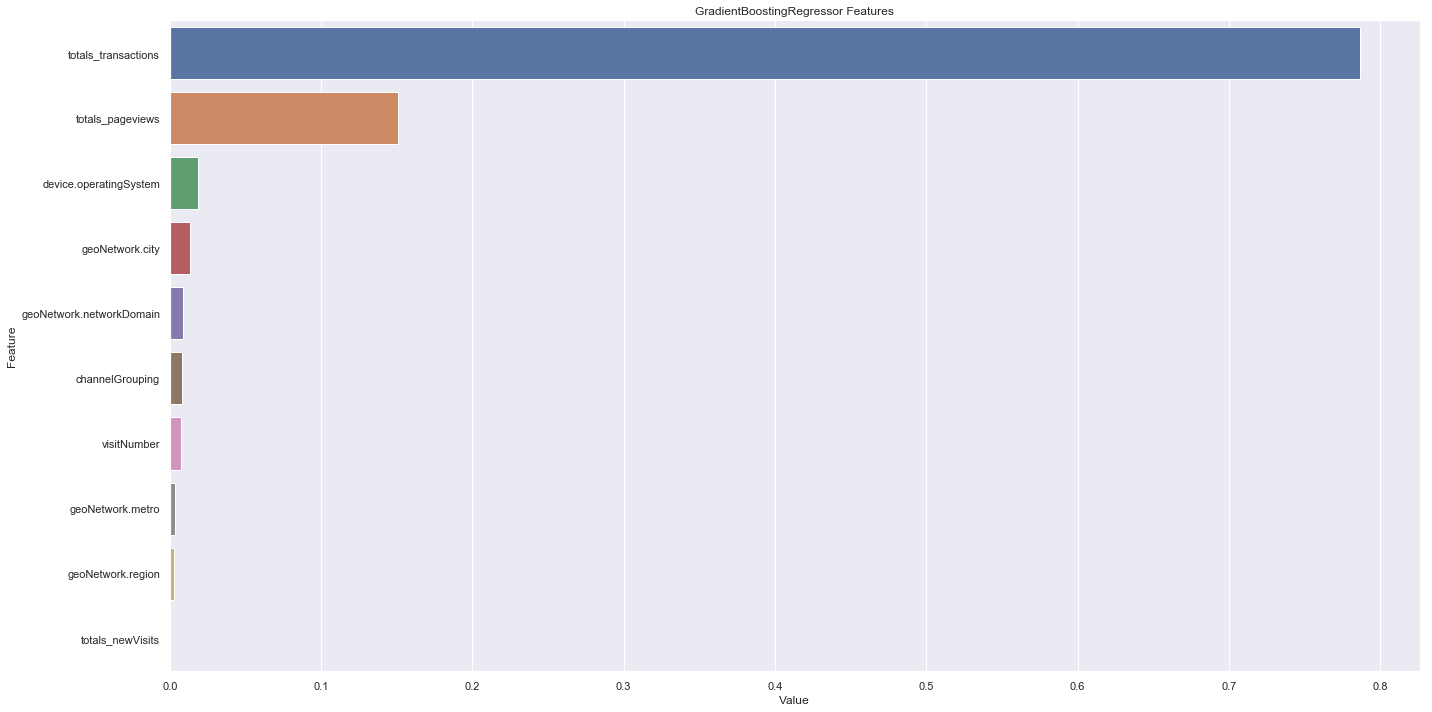

<Figure size 432x288 with 0 Axes>

In [107]:
feature_imp_gbrt = pd.DataFrame(sorted(zip(gbrt.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp_gbrt.sort_values(by="Value", ascending=False).head(10))
plt.title('GradientBoostingRegressor Features')
plt.tight_layout()
plt.show()
plt.savefig('gbrt_importances-01.png')


In [152]:
# Evaluation of gbrt
y_pred_gbrt=gbrt.predict(X_test) 
rms_gbrt = np.sqrt(mean_squared_error(y_test, y_pred_gbrt))  #1.139185
print("RMSE:{e}".format(e=rms_gbrt))
print("r2 Score:{}".format(r2_score(y_test, y_pred_gbrt)))
print("explained variance score:{}".format(explained_variance_score(y_test, y_pred_gbrt)))

RMSE:0.2988069927232137
r2 Score:0.9714153792956817
explained variance score:0.9714252214144117


In [153]:
report_table = [['Gradient Boosting', 'learning_rate=0.05, n_estimators=100, subsample=0.9,max_depth= 3,min_samples_leaf=20,min_samples_split=50,max_features=auto', gbrt.score(X_train, y_train), gbrt.score(X_test, y_test), rms_gbrt, r2_score(y_test, y_pred_gbrt), explained_variance_score(y_test, y_pred_gbrt)]]

### Random Forest Regressor 

###### Initial parameter values(will be tuned using grid search cv):criterion= 'mse', max_depth= 5, max_features= 'sqrt', max_leaf_nodes= 5

In [131]:
#random forest
param_grid_rf = {
                   'n_estimators':[100,200,500]
                 
                  }
              
print("Parameter grid:\n{}".format(param_grid_rf))

grid_search_rf = GridSearchCV(RandomForestRegressor(criterion= 'mse', max_depth= 5, max_features= 'sqrt', max_leaf_nodes= 5), param_grid_rf, cv=5, return_train_score=True)
grid_search_rf.fit(X_train,y_train)


Parameter grid:
{'n_estimators': [100, 200, 500]}


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='sqrt', max_leaf_nodes=5,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 200, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [132]:
grid_search_rf.grid_scores_, grid_search_rf.best_params_, grid_search_rf.best_score_

([mean: 0.76115, std: 0.02587, params: {'n_estimators': 100},
  mean: 0.78096, std: 0.02986, params: {'n_estimators': 200},
  mean: 0.76774, std: 0.01270, params: {'n_estimators': 500}],
 {'n_estimators': 200},
 0.7809600165093151)

In [133]:
#random forest
param_grid_rf = {
                  'max_depth': [5,10,15]
                 
                  }
              
print("Parameter grid:\n{}".format(param_grid_rf))

grid_search_rf2 = GridSearchCV(RandomForestRegressor(criterion= 'mse', max_features= 'sqrt', max_leaf_nodes= 5, n_estimators= 200), param_grid_rf, cv=5, return_train_score=True)
grid_search_rf2.fit(X_train,y_train)


Parameter grid:
{'max_depth': [5, 10, 15]}


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=5,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [5, 10, 15]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

In [134]:
grid_search_rf2.grid_scores_, grid_search_rf2.best_params_, grid_search_rf2.best_score_

([mean: 0.80430, std: 0.03686, params: {'max_depth': 5},
  mean: 0.78381, std: 0.02643, params: {'max_depth': 10},
  mean: 0.76498, std: 0.01699, params: {'max_depth': 15}],
 {'max_depth': 5},
 0.8042955159519634)

In [135]:
#random forest
param_grid_rf = {
                  'max_features': [5,10,15,'sqrt','log2','auto'],
    'max_leaf_nodes': [10,20,50,100]
                 
                  }
              
print("Parameter grid:\n{}".format(param_grid_rf))

grid_search_rf4 = GridSearchCV(RandomForestRegressor(criterion= 'mse', max_depth=5, n_estimators= 200), param_grid_rf, cv=5, return_train_score=True)
grid_search_rf4.fit(X_train,y_train)


Parameter grid:
{'max_features': [5, 10, 15, 'sqrt', 'log2', 'auto'], 'max_leaf_nodes': [10, 20, 50, 100]}


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': [5, 10, 15, 'sqrt', 'log2', 'auto'], 'max_leaf_nodes': [10, 20, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [136]:
grid_search_rf4.grid_scores_, grid_search_rf4.best_params_, grid_search_rf4.best_score_

([mean: 0.91543, std: 0.01606, params: {'max_features': 5, 'max_leaf_nodes': 10},
  mean: 0.94615, std: 0.01983, params: {'max_features': 5, 'max_leaf_nodes': 20},
  mean: 0.95564, std: 0.02300, params: {'max_features': 5, 'max_leaf_nodes': 50},
  mean: 0.95152, std: 0.02303, params: {'max_features': 5, 'max_leaf_nodes': 100},
  mean: 0.97415, std: 0.02778, params: {'max_features': 10, 'max_leaf_nodes': 10},
  mean: 0.97619, std: 0.02837, params: {'max_features': 10, 'max_leaf_nodes': 20},
  mean: 0.97631, std: 0.02767, params: {'max_features': 10, 'max_leaf_nodes': 50},
  mean: 0.97560, std: 0.02831, params: {'max_features': 10, 'max_leaf_nodes': 100},
  mean: 0.97458, std: 0.02875, params: {'max_features': 15, 'max_leaf_nodes': 10},
  mean: 0.97473, std: 0.02849, params: {'max_features': 15, 'max_leaf_nodes': 20},
  mean: 0.97475, std: 0.02872, params: {'max_features': 15, 'max_leaf_nodes': 50},
  mean: 0.97484, std: 0.02852, params: {'max_features': 15, 'max_leaf_nodes': 100},
  mea

###### Fit model with best parameters

In [140]:
rf = RandomForestRegressor(criterion= 'mse',  max_depth=5, n_estimators= 200,max_features= 10, max_leaf_nodes= 20,random_state=10)  
rf.fit(X_train, y_train)
  

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features=10, max_leaf_nodes=20, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=1, oob_score=False, random_state=10,
           verbose=0, warm_start=False)

In [141]:
rf.score(X_train, y_train) 

0.9944572201010479

In [142]:
print(rf.feature_importances_)

[1.27480599e-03 3.66319026e-03 4.79105893e-04 1.49557757e-03
 5.78753300e-02 9.23703947e-01 5.95480435e-04 3.11679033e-05
 9.99614175e-04 7.04372191e-04 6.41614205e-04 2.92050170e-03
 2.45384804e-03 1.32240671e-03 8.04410403e-04 6.16833854e-05
 2.76220141e-04 5.88053384e-07 6.96136068e-04]


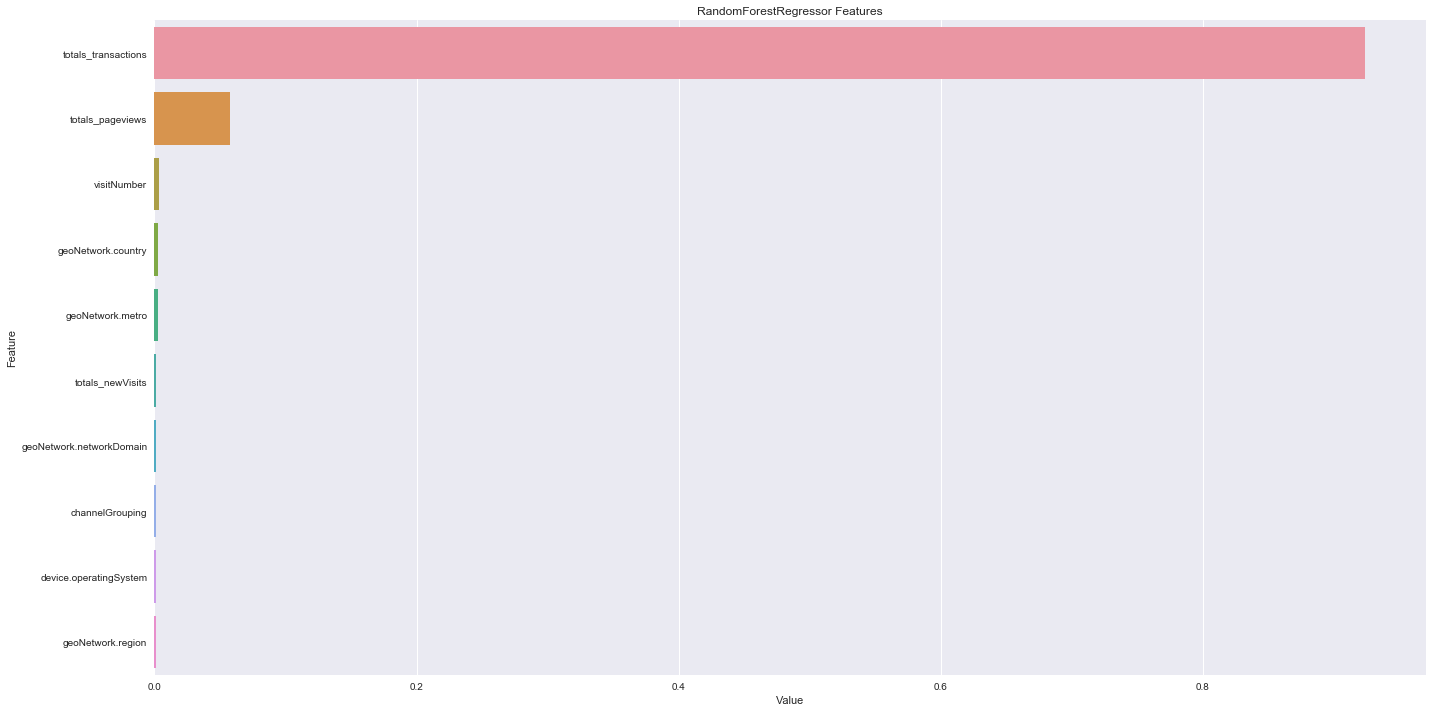

<Figure size 432x288 with 0 Axes>

In [143]:
feature_imp_rf = pd.DataFrame(sorted(zip(rf.feature_importances_,X.columns)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp_rf.sort_values(by="Value", ascending=False).head(10))
plt.title('RandomForestRegressor Features')
plt.tight_layout()
plt.show()
plt.savefig('rf_importances-01.png')

In [145]:
# Evaluation of rf

y_pred = rf.predict(X_test)
rms_rf = np.sqrt(mean_squared_error(y_test, y_pred)) 
print("RMSE:{e}".format(e=rms_rf))
print("r2 Score:{}".format(r2_score(y_test, y_pred)))
print("explained variance score:{}".format(explained_variance_score(y_test, y_pred)))

RMSE:0.3151670560769666
r2 Score:0.9681996023560693
explained variance score:0.9682061829141805


###### RMSE, r2, explained variance for gradient boost regressor train and test

In [150]:
gbrt.score(X_train, y_train) 

0.9866914230818954

In [151]:
gbrt.score(X_test, y_test) 

0.9714153792956817

In [45]:
print("RMSE:{e}".format(e=rms_gbrt))
print("r2 Score:{}".format(r2_score(y_test, y_pred_gbrt)))
print("explained variance score:{}".format(explained_variance_score(y_test, y_pred_gbrt)))

RMSE:0.2988069927232137
r2 Score:0.9714153792956817
explained variance score:0.9714252214144117


###### RMSE, r2, explained variance for random forest regressor train and test

In [46]:
rf.score(X_train, y_train) 

0.9943052499567139

In [47]:
rf.score(X_test, y_test) 

0.9678808520232686

In [49]:
print("RMSE:{e}".format(e=rms_rf))
print("r2 Score:{}".format(r2_score(y_test, y_pred)))
print("explained variance score:{}".format(explained_variance_score(y_test, y_pred)))

RMSE:0.31674265145905117
r2 Score:0.9678808520232686
explained variance score:0.9678876654787518


In [154]:
report_table = report_table + [['Random Forest', 'criterion= mse,  max_depth=5, n_estimators= 200, max_features= 10, max_leaf_nodes= 20', rf.score(X_train, y_train) , rf.score(X_test, y_test), rms_rf, r2_score(y_test, y_pred), explained_variance_score(y_test, y_pred)]]

In [155]:
report = pd.DataFrame(report_table,columns = ['Model name', 'Model parameter', 'Train accuracy', 'Test accuracy', 'Test Root Mean Squared Error(RMSE)', 'Test r2 score', 'Test Explained Variance Score'])

###### From the below table we find that test and train score is closer for Gradient Boosting Model compared to Random Forest. Also, RMSE is smaller for Gradient Boosting Model. Thus, we prefer gradient boosting over the random forest model.

In [156]:
report

,Model name,Model parameter,Train accuracy,Test accuracy,Test Root Mean Squared Error(RMSE),Test r2 score,Test Explained Variance Score
0,Gradient Boosting,"learning_rate=0.05, n_estimators=100, subsampl...",0.986691,0.971415,0.298807,0.971415,0.971425
1,Random Forest,"criterion= mse, max_depth=5, n_estimators= 20...",0.994457,0.968200,0.315167,0.968200,0.968206


### Unsupervised Models

### KMeans Clustering

In [251]:
Sum_of_squared_distances = []
K = range(1,40)
for k in K:
    km = KMeans(k)
    km=km.fit(X_train)
    Sum_of_squared_distances.append(km.inertia_)

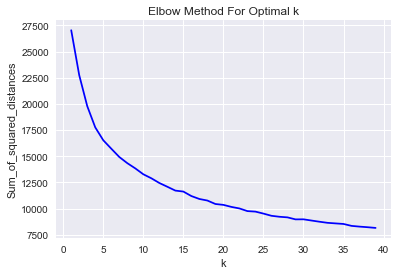

In [252]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

###### In the plot above the elbow is at k=5 indicating the optimal k for this dataset is 5

###### We run model with optimal number of clusters

In [253]:
X_train.shape

(16000, 19)

In [131]:
km = KMeans(5)
km=km.fit(X_train)

In [255]:
y_pred_km=km.predict(X_test)

In [256]:
km.inertia_

16529.48578996391

In [257]:
score = metrics.silhouette_score(X_test, y_pred_km)
print ('Silhouette Score:', score)

Silhouette Score: 0.18126852440366684


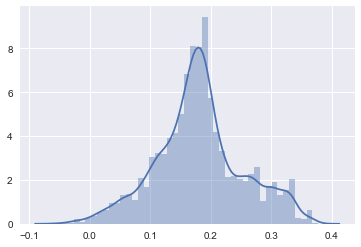

In [258]:
scores = metrics.silhouette_samples(X_test, y_pred_km)
sns.distplot(scores);

In [259]:
rand_score = adjusted_rand_score(y_test, y_pred_km)
rand_score

0.0019123967192397116

### Gaussian Mixture Model

In [287]:
lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(X_train)
        bic.append(gmm.bic(X_train))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'green',
                              'orange'])
color_iter2 = itertools.cycle(['navy', 'turquoise', 'green',
                              'orange', 'pink', 'yellow'])
clf = best_gmm

In [288]:
clf

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=5, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

###### Plot of BIC scores

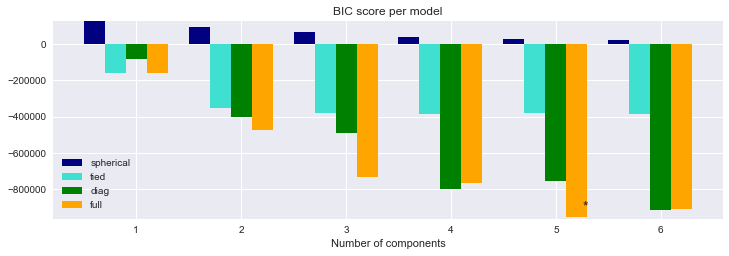

In [289]:
bars = []
plt.figure(figsize=(12, 8))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)
plt.show()

###### From the above plot, we find that the optimal number of components is 6 with coariance type full.

###### We run model with optimal number of components

In [290]:
model = GaussianMixture(n_components=6, covariance_type='full') 
model.fit(X_train)                                               

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=6, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [291]:
y_pred_gmm=model.predict(X_test)

###### Plot of n_components=6 and covariance type = full

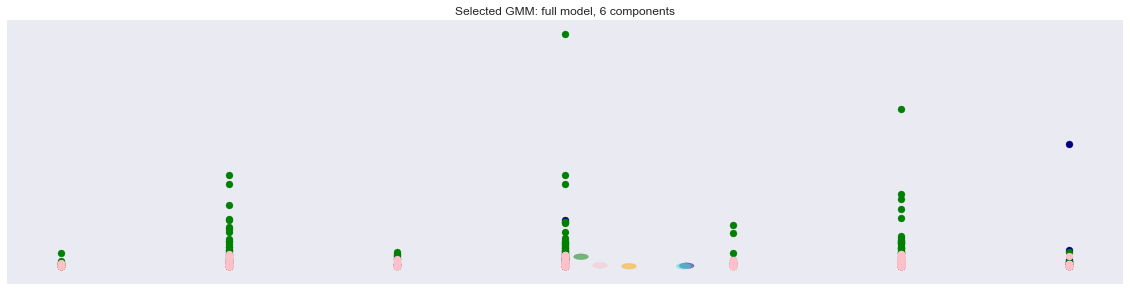

In [294]:
plt.figure(figsize=(20, 10))
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X_test)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter2)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X_test[Y_ == i, 0], X_test[Y_ == i, 1],  color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 6. * np.sqrt(6.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title('Selected GMM: full model, 6 components')
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

In [295]:
rand_score_gmm = adjusted_rand_score(y_test, y_pred_gmm)
rand_score_gmm

-0.0070322885294549185

In [303]:
report_table_un = [['KMeans', 'n_clusters=4', rand_score]]

In [304]:
report_table_un = report_table_un + [['Gaussian Mixture', 'n_components=6, covariance_type=full', rand_score_gmm]]

In [305]:
report_un = pd.DataFrame(report_table_un,columns = ['Model name', 'Model parameter', 'Adjusted Rand Score'])

###### From the adjusted rand score for kmeans and GMM given below, we find that KMeans clustering matched the true labels more closely than the GMM

In [306]:
report_un

,Model name,Model parameter,Adjusted Rand Score
0,KMeans,n_clusters=4,0.001912
1,Gaussian Mixture,"n_components=6, covariance_type=full",-0.007032


### Dimensionality Reduction

### PCA

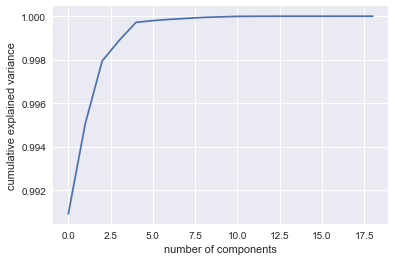

In [70]:
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

###### We see that our two-dimensional projection loses a lot of information (as measured by the explained variance) and that we'd need about 9 components to retain 90% of the variance.

In [71]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)  
X_test_pca = pca.transform(X_test)  

In [72]:
print(pca.components_)

[[ 0.08774497 -0.00467164  0.48522232  0.29715105 -0.02210635 -0.00743968
   0.04947399  0.03119431  0.0899566  -0.25738533  0.12300006 -0.24544145
  -0.3464325   0.12005125 -0.11249739  0.02578093  0.26316977 -0.3940804
  -0.3775699 ]
 [-0.10142766  0.003489    0.85902295 -0.28627784 -0.02659399 -0.00180766
   0.01324847  0.02891668 -0.02910672  0.16508691 -0.01345153  0.0818957
   0.15476067 -0.03768348  0.09184364  0.00154189 -0.14837163  0.22221627
   0.16706626]]


In [73]:
print(pca.explained_variance_)

[0.367065   0.21745397]


###### variance ratios for each principal component

In [74]:
explained_variance_ratio = pca.explained_variance_ratio_  
explained_variance_ratio 

array([0.2172271 , 0.12868809])

In [75]:
print("original shape:   ", X_train.shape)
print("transformed shape:", X_train_pca.shape)

original shape:    (16000, 19)
transformed shape: (16000, 2)


###### Random Forest Regressor on PCA components

In [106]:
reg = RandomForestRegressor(criterion= 'mse',  max_depth=5, n_estimators= 200,max_features= 2, max_leaf_nodes= 20,random_state=10)   
reg.fit(X_train_pca, y_train)

y_pred = reg.predict(X_test_pca)  

In [107]:
print(reg.predict([[0,0]]))

[0.00998108]


In [108]:
print(reg.feature_importances_)

[0.54335302 0.45664698]


In [109]:
rms_rf = np.sqrt(mean_squared_error(y_test, y_pred)) 
print("RMSE:{e}".format(e=rms_rf))
print("r2 Score:{}".format(r2_score(y_test, y_pred)))
print("explained variance score:{}".format(explained_variance_score(y_test, y_pred)))

RMSE:1.6903582487037292
r2 Score:0.0852373267790616
explained variance score:0.08530174853638961


###### Gradient Boosting Regressor on PCA components

In [99]:
gbrt=GradientBoostingRegressor(learning_rate=0.05, n_estimators=100, subsample=0.9,max_depth= 3,min_samples_leaf=20,min_samples_split=50,max_features=2, random_state=10)
 
gbrt.fit(X_train_pca, y_train) 

y_pred_gb = gbrt.predict(X_test_pca)

In [100]:
print(gbrt.predict([[0, 0]]))

[0.01717149]


In [101]:
print(gbrt.feature_importances_)

[0.54179549 0.45820451]


In [102]:
rms_gbrt = np.sqrt(mean_squared_error(y_test, y_pred_gb))  
print("RMSE:{e}".format(e=rms_gbrt))
print("r2 Score:{}".format(r2_score(y_test, y_pred_gb)))
print("explained variance score:{}".format(explained_variance_score(y_test, y_pred_gb)))

RMSE:1.7411389482263873
r2 Score:0.02945029586624126
explained variance score:0.029474917967631686


In [105]:
report_table_pca = [['Gradient Boosting', 'learning_rate=0.05, n_estimators=100, subsample=0.9,max_depth= 3,min_samples_leaf=20,min_samples_split=50,max_features=2', gbrt.score(X_train_pca, y_train), gbrt.score(X_test_pca, y_test), rms_gbrt, r2_score(y_test, y_pred_gb), explained_variance_score(y_test, y_pred_gb)]]

In [110]:
report_table_pca = report_table_pca + [['Random Forest', 'criterion= mse,  max_depth=5, n_estimators= 200,max_features= 2, max_leaf_nodes= 20,', reg.score(X_train_pca, y_train) , reg.score(X_test_pca, y_test), rms_rf, r2_score(y_test, y_pred), explained_variance_score(y_test, y_pred)]]

In [111]:
report_pca = pd.DataFrame(report_table_pca,columns = ['Model name', 'Model parameter', 'Train accuracy', 'Test accuracy', 'Test Root Mean Squared Error(RMSE)', 'Test r2 score', 'Test Explained Variance Score'])

In [112]:
report_pca

,Model name,Model parameter,Train accuracy,Test accuracy,Test Root Mean Squared Error(RMSE),Test r2 score,Test Explained Variance Score
0,Gradient Boosting,"learning_rate=0.05, n_estimators=100, subsampl...",0.128994,0.029450,1.741139,0.029450,0.029475
1,Random Forest,"criterion= mse, max_depth=5, n_estimators= 20...",0.209811,0.085237,1.690358,0.085237,0.085302


###### From the above table we find the RMSE value for Random Forest is better compared to Gradient Bossting after applying PCA.

###### After applying PCA, we find that the RMSE values for supervised model has increased and the r2 score has decreased compared to the original model.

### Isomap

In [30]:
embedding = Isomap(n_components=2)
X_train_transformed = embedding.fit_transform(X_train)
X_train_transformed.shape

(16000, 2)

In [31]:
X_test_transformed = embedding.transform(X_test)
X_test_transformed.shape

(4000, 2)

###### Random Forest Regressor on transformed data

In [118]:
reg = RandomForestRegressor(criterion= 'mse',  max_depth=5, n_estimators= 200,max_features= 2, max_leaf_nodes= 20,random_state=10)   
reg.fit(X_train_transformed, y_train)

y_pred = reg.predict(X_test_transformed)  

In [119]:
print(reg.predict([[0,0]]))

[0.05495756]


In [120]:
print(reg.feature_importances_)

[0.48783245 0.51216755]


In [121]:
rms_rf = np.sqrt(mean_squared_error(y_test, y_pred)) 
print("RMSE:{e}".format(e=rms_rf))
print("r2 Score:{}".format(r2_score(y_test, y_pred)))
print("explained variance score:{}".format(explained_variance_score(y_test, y_pred)))

RMSE:1.6805852437919322
r2 Score:0.0957843647604456
explained variance score:0.09583049841079039


###### Gradient Boosting Regressor on  transformed data

In [113]:
gbrt=GradientBoostingRegressor(learning_rate=0.05, n_estimators=100, subsample=0.9,max_depth= 3,min_samples_leaf=20,min_samples_split=50,max_features=2, random_state=10)
 
gbrt.fit(X_train_transformed, y_train) 

y_pred_gb = gbrt.predict(X_test_transformed)

In [114]:
print(gbrt.predict([[0, 0]]))

[0.10024812]


In [115]:
print(gbrt.feature_importances_)

[0.58059872 0.41940128]


In [116]:
rms_gbrt = np.sqrt(mean_squared_error(y_test, y_pred_gb))  
print("RMSE:{e}".format(e=rms_gbrt))
print("r2 Score:{}".format(r2_score(y_test, y_pred_gb)))
print("explained variance score:{}".format(explained_variance_score(y_test, y_pred_gb)))

RMSE:1.706657827407131
r2 Score:0.06751074894504128
explained variance score:0.0675160890476395


In [117]:
report_table_iso = [['Gradient Boosting', 'learning_rate=0.05, n_estimators=100, subsample=0.9,max_depth= 3,min_samples_leaf=20,min_samples_split=50,max_features=2', gbrt.score(X_train_transformed, y_train), gbrt.score(X_test_transformed, y_test), rms_gbrt, r2_score(y_test, y_pred_gb), explained_variance_score(y_test, y_pred_gb)]]

In [122]:
report_table_iso = report_table_iso + [['Random Forest', 'criterion= mse,  max_depth=5, n_estimators= 200,max_features= 2, max_leaf_nodes= 20,', reg.score(X_train_transformed, y_train) , reg.score(X_test_transformed, y_test), rms_rf, r2_score(y_test, y_pred), explained_variance_score(y_test, y_pred)]]

In [123]:
report_iso = pd.DataFrame(report_table_iso,columns = ['Model name', 'Model parameter', 'Train accuracy', 'Test accuracy', 'Test Root Mean Squared Error(RMSE)', 'Test r2 score', 'Test Explained Variance Score'])

In [126]:
report_iso

,Model name,Model parameter,Train accuracy,Test accuracy,Test Root Mean Squared Error(RMSE),Test r2 score,Test Explained Variance Score
0,Gradient Boosting,"learning_rate=0.05, n_estimators=100, subsampl...",0.135906,0.067511,1.706658,0.067511,0.067516
1,Random Forest,"criterion= mse, max_depth=5, n_estimators= 20...",0.204283,0.095784,1.680585,0.095784,0.095830


###### From the above table we find that RMSE is lesser for Random Forest model compared to Gradient Boosting after dimensionality reduction. 

###### After applying transformation, we find that the RMSE values for supervised model has increased and the r2 score has decreased compared to the original model.

###### PCA results

In [112]:
report_pca

,Model name,Model parameter,Train accuracy,Test accuracy,Test Root Mean Squared Error(RMSE),Test r2 score,Test Explained Variance Score
0,Gradient Boosting,"learning_rate=0.05, n_estimators=100, subsampl...",0.128994,0.029450,1.741139,0.029450,0.029475
1,Random Forest,"criterion= mse, max_depth=5, n_estimators= 20...",0.209811,0.085237,1.690358,0.085237,0.085302


###### Supervised learning models results

In [156]:
report

,Model name,Model parameter,Train accuracy,Test accuracy,Test Root Mean Squared Error(RMSE),Test r2 score,Test Explained Variance Score
0,Gradient Boosting,"learning_rate=0.05, n_estimators=100, subsampl...",0.986691,0.971415,0.298807,0.971415,0.971425
1,Random Forest,"criterion= mse, max_depth=5, n_estimators= 20...",0.994457,0.968200,0.315167,0.968200,0.968206


###### Comparing the performance results for the supervised models before and after pca and Isomap trasformation, we find that the r2 score, explained variance and RMSE are better for the original models than the ones after dimensionality reduction.  

### Neural Network Model

In [27]:
BATCH_SIZE = 36
EPOCHS = 20
LEARNING_RATE = 0.0003

In [30]:
model = Sequential()
model.add(Dense(256, kernel_initializer='glorot_normal', activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(128, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(1))

In [31]:
adam = optimizers.adam(lr=LEARNING_RATE)
model.compile(loss='mse', optimizer=adam)

In [33]:
history = model.fit(x=X_train, y=y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    verbose=1, validation_data=(X_test, y_test))

Train on 16000 samples, validate on 4000 samples
Epoch 1/20
16000/16000 [==============================] - 5s 315us/step - loss: 2.6105 - val_loss: 2.1080
Epoch 2/20
16000/16000 [==============================] - 3s 159us/step - loss: 1.1726 - val_loss: 0.4609
Epoch 3/20
16000/16000 [==============================] - 3s 158us/step - loss: 0.2318 - val_loss: 0.1646
Epoch 4/20
16000/16000 [==============================] - 3s 159us/step - loss: 0.1173 - val_loss: 0.1515
Epoch 5/20
16000/16000 [==============================] - 3s 163us/step - loss: 0.1031 - val_loss: 0.1463
Epoch 6/20
16000/16000 [==============================] - 3s 198us/step - loss: 0.0980 - val_loss: 0.1447
Epoch 7/20
16000/16000 [==============================] - 3s 214us/step - loss: 0.0915 - val_loss: 0.1266
Epoch 8/20
16000/16000 [==============================] - 3s 210us/step - loss: 0.0871 - val_loss: 0.1217
Epoch 9/20
16000/16000 [==============================] - 3s 175us/step - loss: 0.0811 - val_loss: 0.11

In [34]:
val_predictions = model.predict(X_test)
mse = mean_squared_error(val_predictions, y_test)
rmse = np.sqrt(mean_squared_error(val_predictions, y_test))

print('Model validation metrics')
print('MSE: %.2f' % mse)
print('RMSE: %.2f' % rmse)
print("r2 Score:{}".format(r2_score(y_test,val_predictions)))
print("explained variance score:{}".format(explained_variance_score(y_test, val_predictions)))

Model validation metrics
MSE: 0.10
RMSE: 0.31
r2 Score:0.9691466127916283
explained variance score:0.9693756445505127


###### Comparing the results from the suervised models and the neural network model we find that the RMSE is least for the Neural Network model.